# ZRE Naive Autotune
Author: Marek Hric xhricma00  
GitHub repo: https://github.com/Marek324/butfit-zre/  
Google Collab notebook: TDB after completion i guess

Original audio source: https://www.openslr.org/resources/12/dev-clean.tar.gz

## Project pipeline
1. Load downsampled audio file ([code](#load-downsampled-audio-file))
2. Center the signal ([code](#center))
3. Frame the signal ([code](#framing))
7. Synthesis ([code](#synthesis))

#### Plotting

In [91]:
# set to True for plots
PLOT = True

### Load downsampled audio file

In [92]:
import random as rand
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sg
import librosa
from IPython.display import Audio, display

s, Fs = librosa.load("input.wav", sr=16000)
s = librosa.effects.preemphasis(s, coef=0.2)

print(f"Signal length: {len(s)} samples")
print(f"Duration: {len(s)/Fs:.2f} s")

display(Audio(s, rate=Fs))

Signal length: 160000 samples
Duration: 10.00 s


### Center

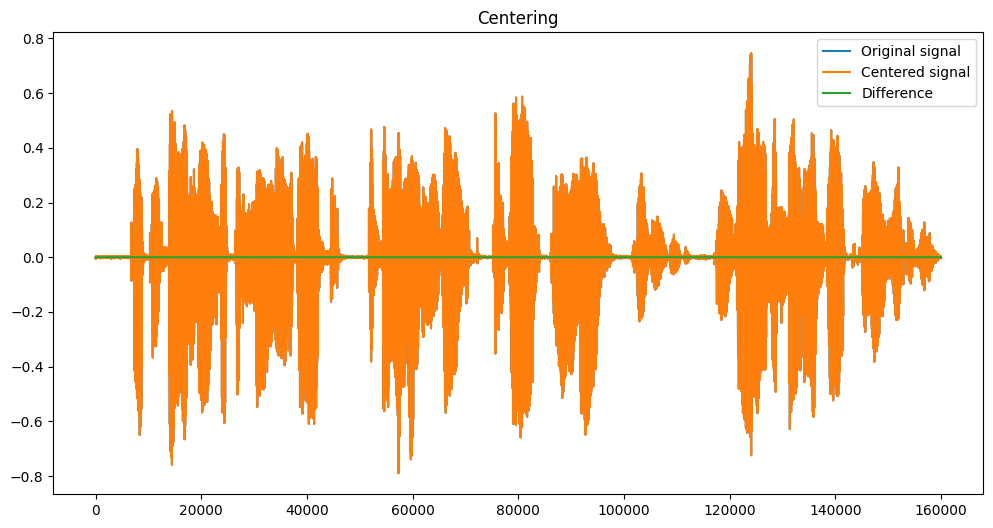

In [93]:
sc = s - np.mean(s)

if PLOT:
  plt.figure(figsize=(12,6))
  plt.title('Centering')
  plt.plot(s, label='Original signal')
  plt.plot(sc, label='Centered signal')
  plt.plot(s-sc, label='Difference')
  plt.legend()
  plt.show()

s = sc

<ipython-input-94-f0c53a862b05>:5: UserWarning: With fmin=65.406, sr=16000 and frame_length=320, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=100.000 or frame_length=491.
  f0s, voiced, _ = librosa.pyin(


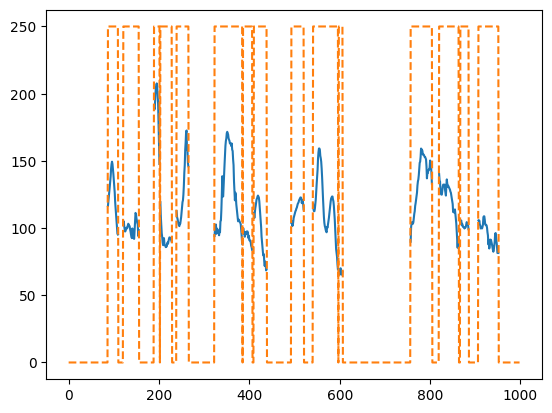

In [94]:
fl = int(Fs * 0.02)
fo = int(Fs * 0.01)
fs = fl - fo

f0s, voiced, _ = librosa.pyin(
    s,
    fmin = librosa.note_to_hz('C2'),
    fmax = librosa.note_to_hz('C6'),
    sr = Fs,
    frame_length = fl,
    hop_length = fs,
    center = False
)

if PLOT:
  plt.plot(f0s)
  plt.plot(voiced*250, "--")
  plt.show()

In [95]:
seq = []
seqs = []

for i, v in enumerate(voiced):
  if v == 0:
    if len(seq) > 0:
      seqs.append(seq)
    seq = []
  else:
    if not np.isnan(f0s[i]):
      seq.append([i, int(f0s[i])])
# last
if len(seq) > 0:
    seqs.append(seq)

### Melody generation

In [96]:
def note(hz:float) -> str:
  return librosa.hz_to_note(hz)

def pitch(note:str) -> float:
  return librosa.note_to_hz(note)

def inc_octave(hz:float) -> float:
  n = note(hz)
  return pitch(n[:-1] + str(int(n[-1])+1))

def dec_octave(hz:float) -> float:
  n = note(hz)
  return pitch(n[:-1] + str(int(n[-1])-1))


def semitone_shift(hz: float, steps: int) -> float:
    midi = librosa.hz_to_midi(hz)
    return librosa.midi_to_hz(midi + steps)

def inc_semitone(hz: float) -> float:
    return semitone_shift(hz, +1)

def dec_semitone(hz: float) -> float:
    return semitone_shift(hz, -1)

first_seq_f0s = [item[1] for item in seqs[0]]
# convert to closest musical note
F0base = pitch(note(int(np.mean(first_seq_f0s))))
print(f"F0base =      {F0base:.2f} Hz ({note(F0base)})")
m_base = inc_octave(F0base)
print(f"Melody base = {m_base:.2f} Hz ({note(m_base)})")

def rand_melody(base_freq: float, semitone_range=(-4, 4), count=8, duration=0.4):
    melody = []
    for _ in range(count):
        shift = rand.randint(semitone_range[0], semitone_range[1])
        shifted_freq = librosa.midi_to_hz(librosa.hz_to_midi(base_freq) + shift)
        melody.append((shifted_freq, duration))
    return melody

# loop for whole signal
melody = rand_melody(m_base, semitone_range=(-3, 4))
melody += melody + melody
melody = melody[:25]

for i, (freq, dur) in enumerate(melody):
  print(f"Note {i+1}: {freq:.2f} Hz ({note(freq)}), duration: {dur}s")

def curr_pitch(n:int) -> float:
  start = 0
  last = 0
  for m in melody:
    if start > n:
      break
    last= float(f"{m[0]:.2f}")
    start += m[1]*Fs
  return last

def curr_lag(n:int) -> int:
  return int(Fs // curr_pitch(n))

F0base =      123.47 Hz (B2)
Melody base = 246.94 Hz (B3)
Note 1: 246.94 Hz (B3), duration: 0.4s
Note 2: 293.66 Hz (D4), duration: 0.4s
Note 3: 246.94 Hz (B3), duration: 0.4s
Note 4: 277.18 Hz (C♯4), duration: 0.4s
Note 5: 233.08 Hz (A♯3), duration: 0.4s
Note 6: 207.65 Hz (G♯3), duration: 0.4s
Note 7: 233.08 Hz (A♯3), duration: 0.4s
Note 8: 293.66 Hz (D4), duration: 0.4s
Note 9: 246.94 Hz (B3), duration: 0.4s
Note 10: 293.66 Hz (D4), duration: 0.4s
Note 11: 246.94 Hz (B3), duration: 0.4s
Note 12: 277.18 Hz (C♯4), duration: 0.4s
Note 13: 233.08 Hz (A♯3), duration: 0.4s
Note 14: 207.65 Hz (G♯3), duration: 0.4s
Note 15: 233.08 Hz (A♯3), duration: 0.4s
Note 16: 293.66 Hz (D4), duration: 0.4s
Note 17: 246.94 Hz (B3), duration: 0.4s
Note 18: 293.66 Hz (D4), duration: 0.4s
Note 19: 246.94 Hz (B3), duration: 0.4s
Note 20: 277.18 Hz (C♯4), duration: 0.4s
Note 21: 233.08 Hz (A♯3), duration: 0.4s
Note 22: 207.65 Hz (G♯3), duration: 0.4s
Note 23: 233.08 Hz (A♯3), duration: 0.4s
Note 24: 293.66 Hz 

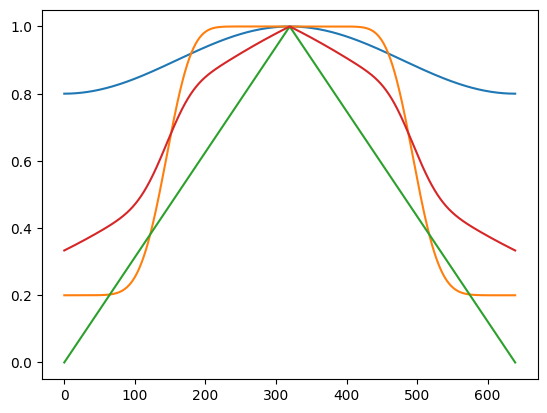

In [97]:
a = sg.windows.general_hamming(fl*2, 0.9)
b = sg.windows.kaiser_bessel_derived(fl*2, np.pi*15)*0.8 + 0.2
c = sg.windows.bartlett(fl*2)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot((a+b+c)/3)

### GCI detection

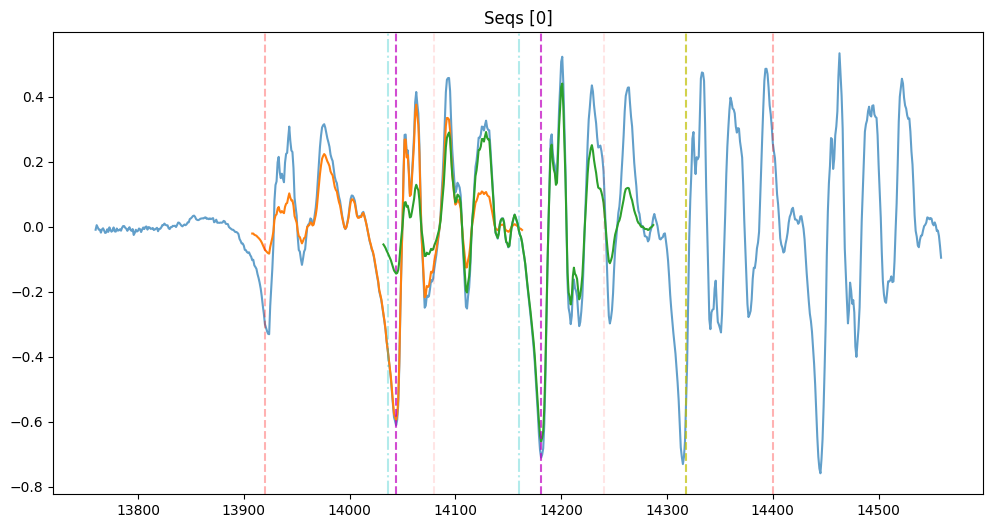

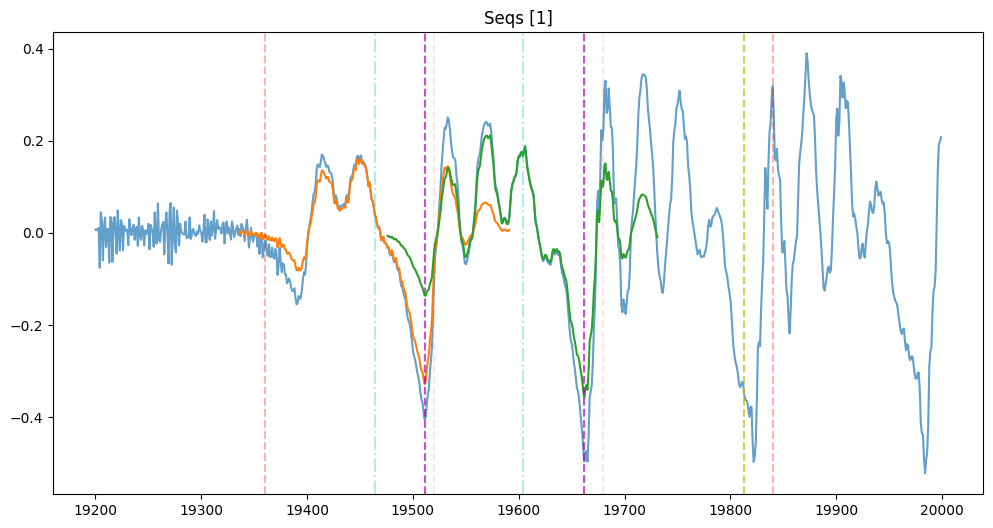

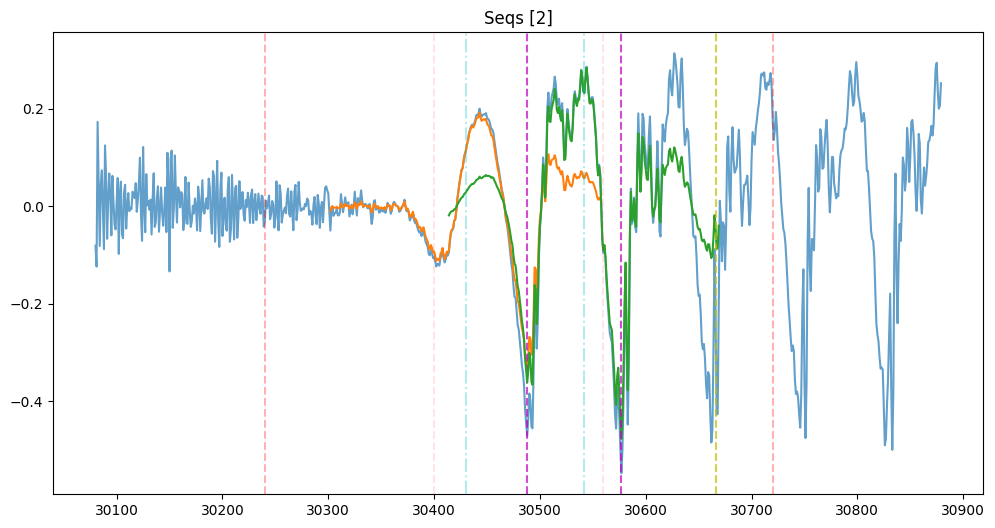

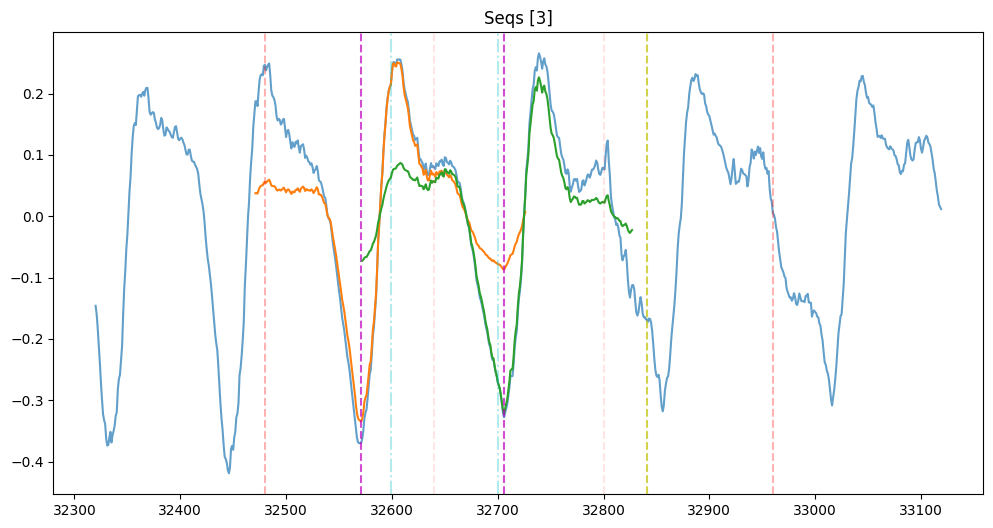

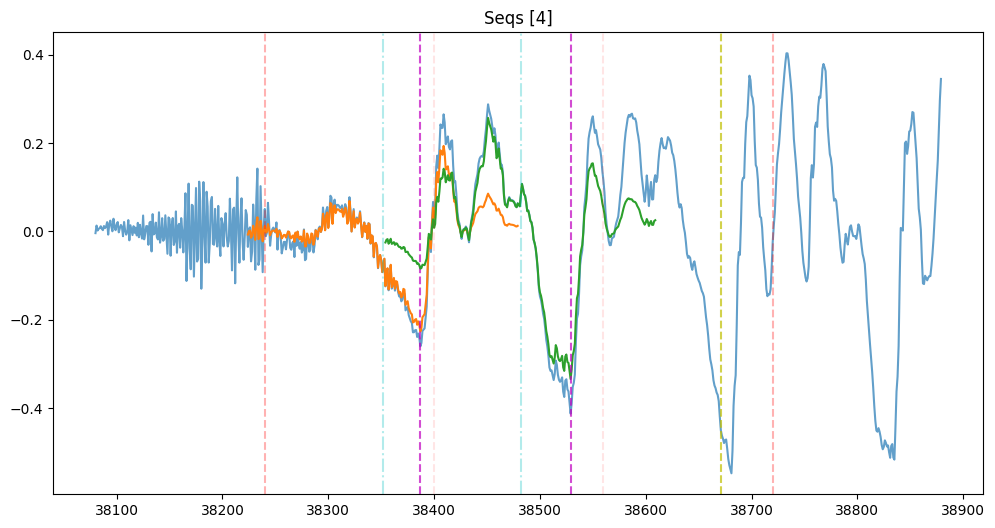

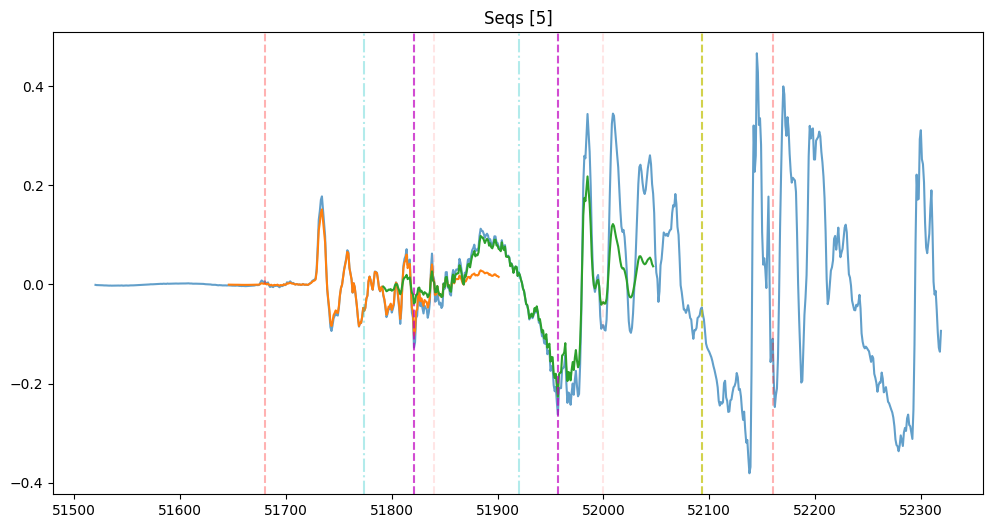

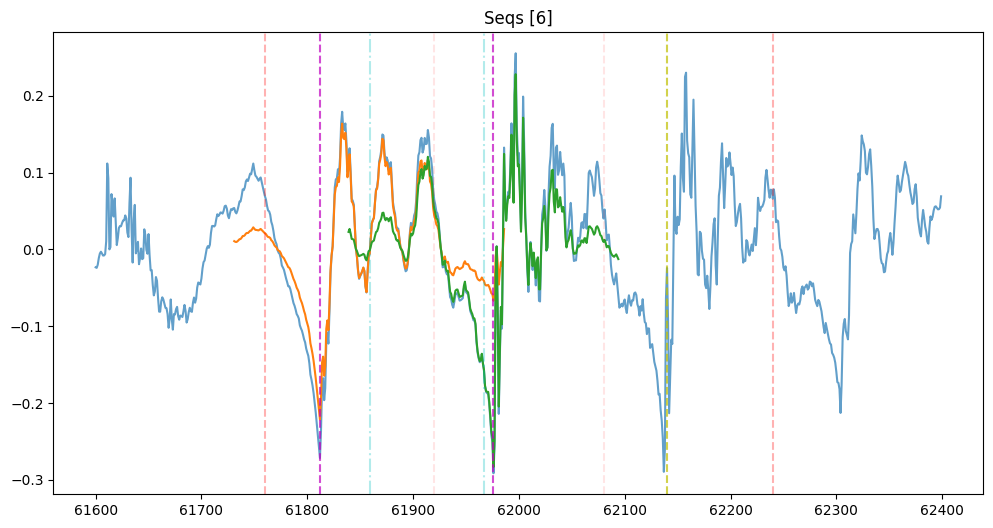

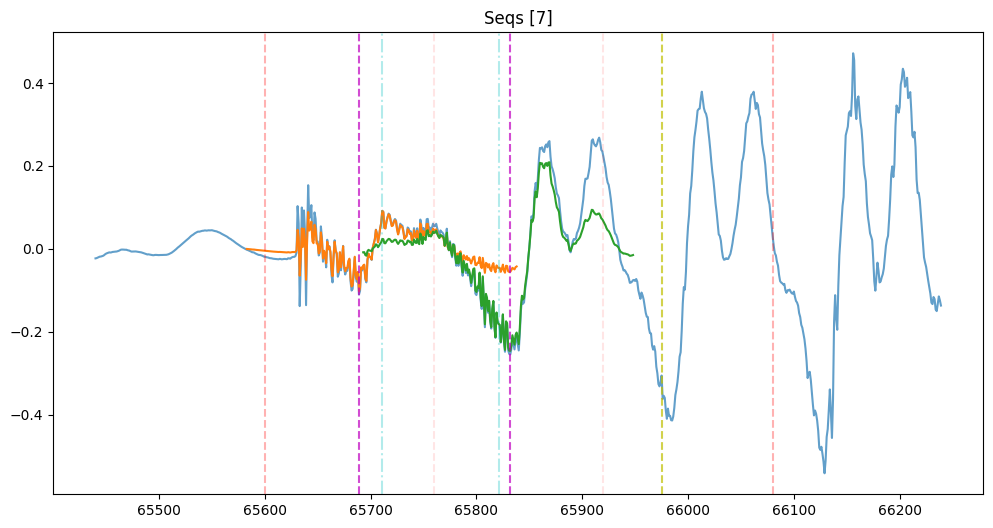

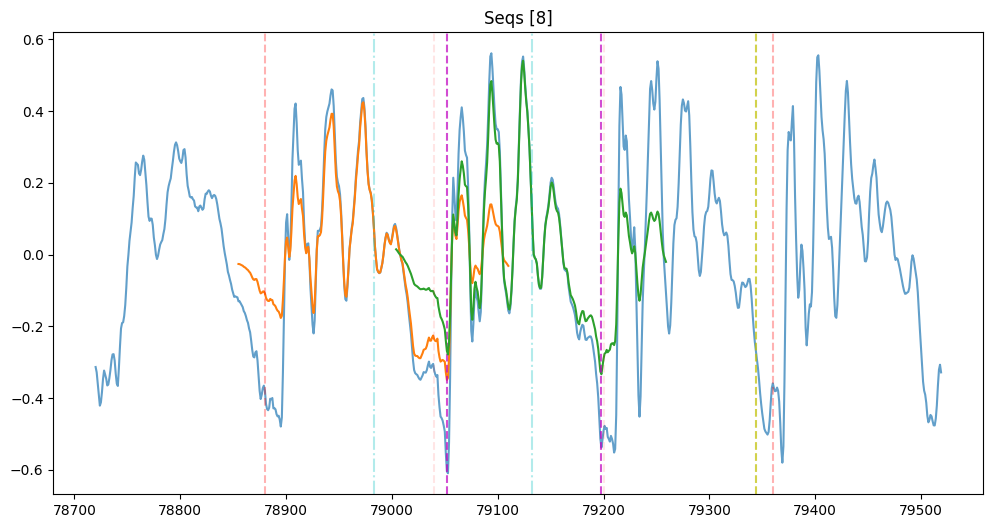

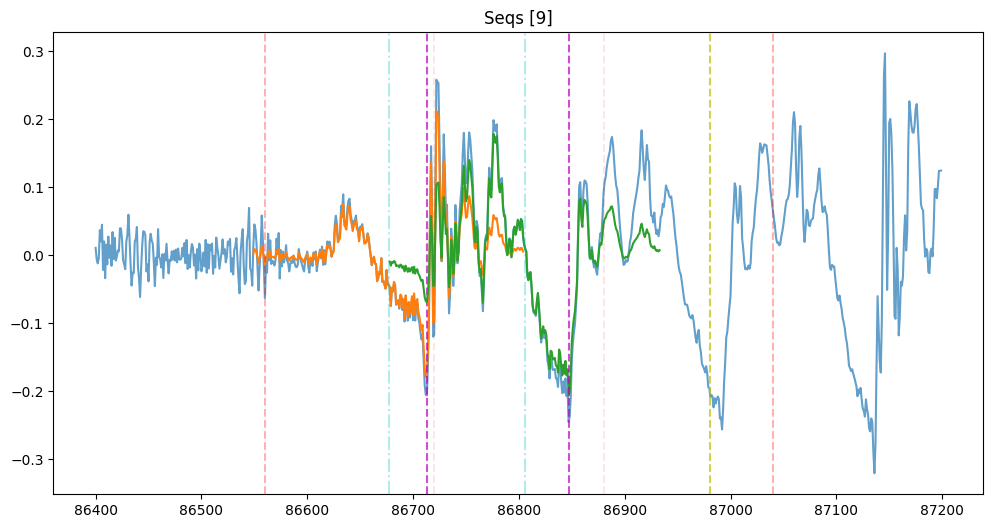

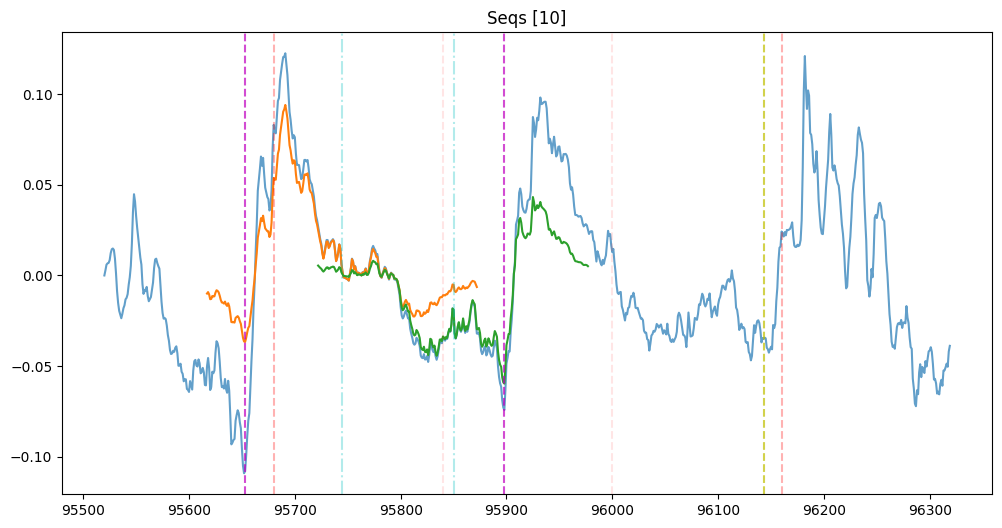

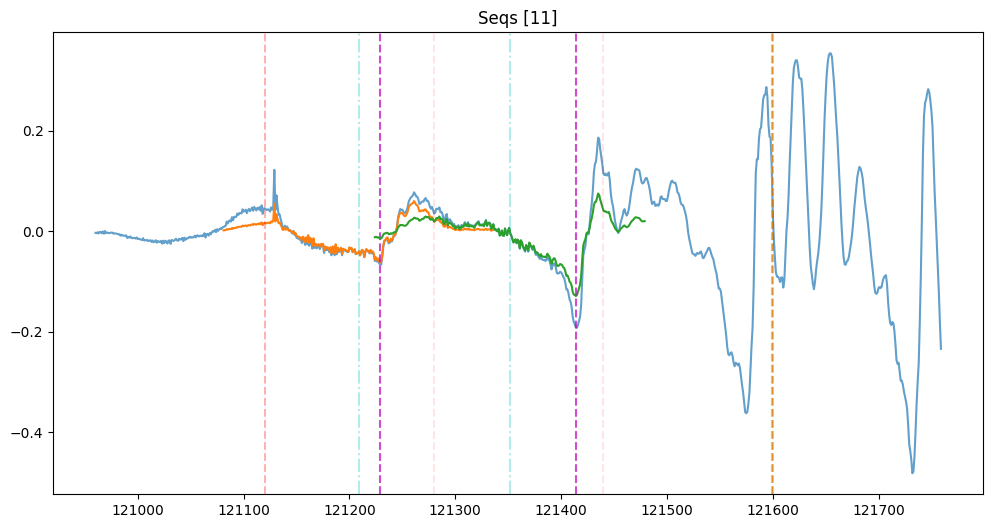

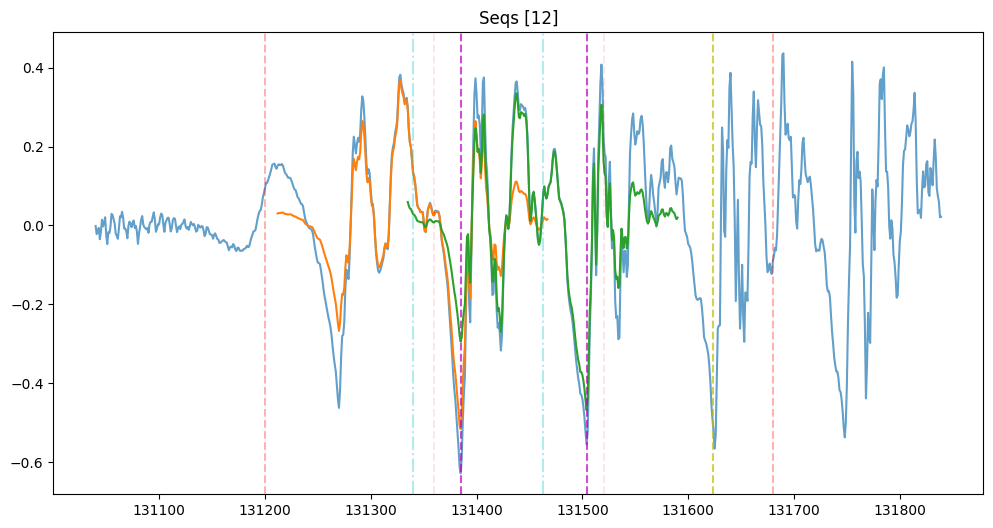

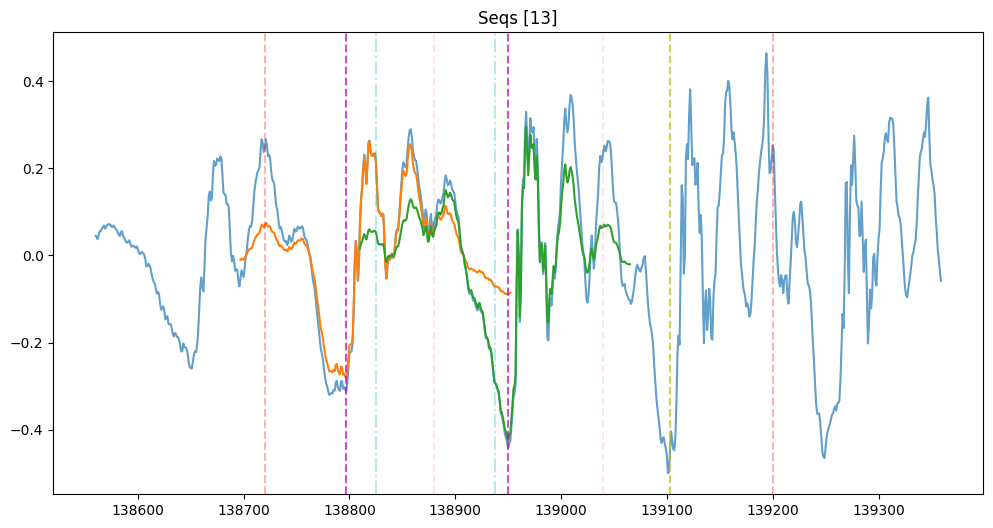

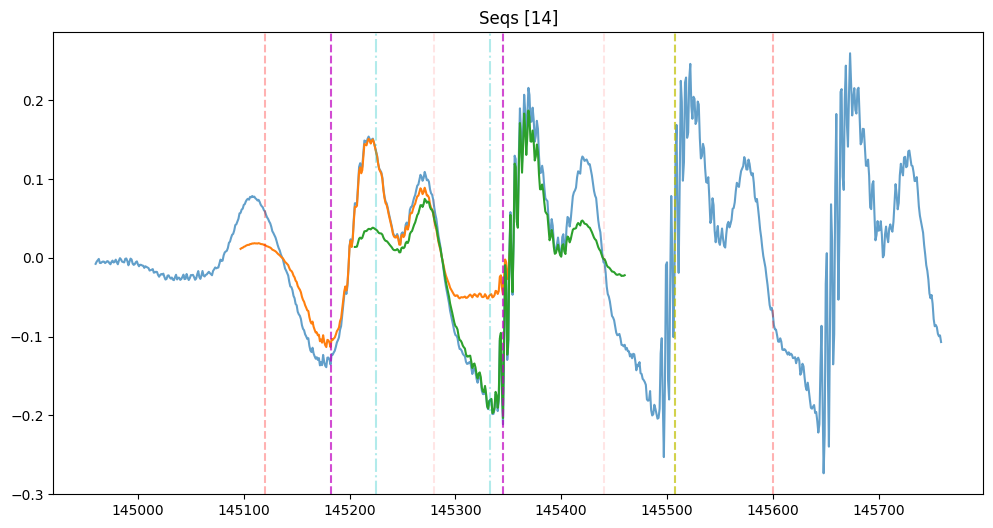

In [98]:
def f_start(f_idx:int, fs:int = 160) -> int:
  return f_idx * fs

pitch_marks = []
for i in range(len(seqs)):
  fi = seqs[i][0]
  start = f_start(fi[0])
  a_mark = start + fi[1]

  search_range = int(fs*0.8)
  weight_window = (
    sg.windows.general_hamming(search_range*2, 0.7) +
    (sg.windows.kaiser_bessel_derived(search_range*2, np.pi*15)*0.8 + 0.2) +
    sg.windows.bartlett(search_range*2)
  ) / 3

  search_window = s[a_mark-search_range:a_mark+search_range] * weight_window
  mark = a_mark + np.argmin(search_window) - search_range

  fi2 = seqs[i][1]
  start2 = f_start(fi2[0])
  err_w = 0.35
  a_mark2 = int(start2 + (1-err_w)*fi2[1] + err_w*(mark - a_mark))

  search_window2 = s[a_mark2-search_range:a_mark2+search_range] * weight_window
  mark2 = a_mark2 + np.argmin(search_window2) - search_range

  seq_pm = [0, int(mark), int(mark2)]
  for j in range(3, len(seqs[i])):
    seq_pm.append(0)

  pitch_marks.append(seq_pm)

  if PLOT:
    zoom_s = start - fs
    zoom_e = start + 2 * fl
    zoom = np.arange(zoom_s, zoom_e)
    plt.figure(figsize=(12,6))
    plt.title(f"Seqs [{i}]")
    plt.plot(zoom, s[zoom_s:zoom_e], alpha=0.7)

    sw_zoom = np.arange(a_mark-search_range, a_mark+search_range)
    plt.plot(sw_zoom, search_window, alpha=1)

    plt.axvline(a_mark, color='c', linestyle='-.', alpha=0.3)
    plt.axvline(mark, color='m', linestyle='--', alpha=0.7)

    sw_zoom2 = np.arange(a_mark2-search_range, a_mark2+search_range)
    plt.plot(sw_zoom2, search_window2, alpha=1)

    plt.axvline(a_mark2, color='c', linestyle='-.', alpha=0.3)
    plt.axvline(mark2, color='m', linestyle='--', alpha=0.7)

    plt.axvline(mark2 + (mark2-mark), color='y', linestyle='--', alpha=0.7)

    plt.axvline(start, color='r', linestyle='--', alpha=0.3)
    plt.axvline(start + fl, color='r', linestyle='--', alpha=0.1)
    plt.axvline(start2, color='r', linestyle='--', alpha=0.1)
    plt.axvline(start2 + fl, color='r', linestyle='--', alpha=0.3)
    plt.show()

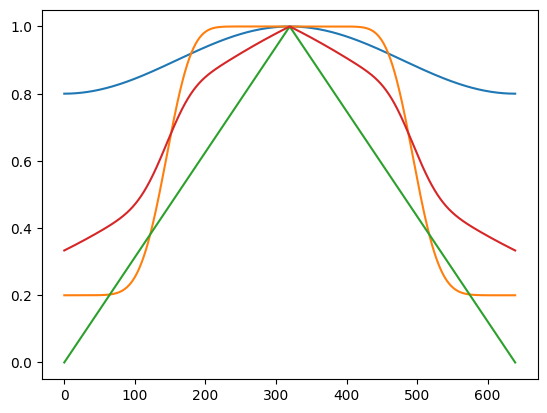

In [99]:
a = sg.windows.general_hamming(fl*2, 0.9)
b = sg.windows.kaiser_bessel_derived(fl*2, np.pi*15)*0.8 + 0.2
c = sg.windows.bartlett(fl*2)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot((a+b+c)/3)
plt.show()

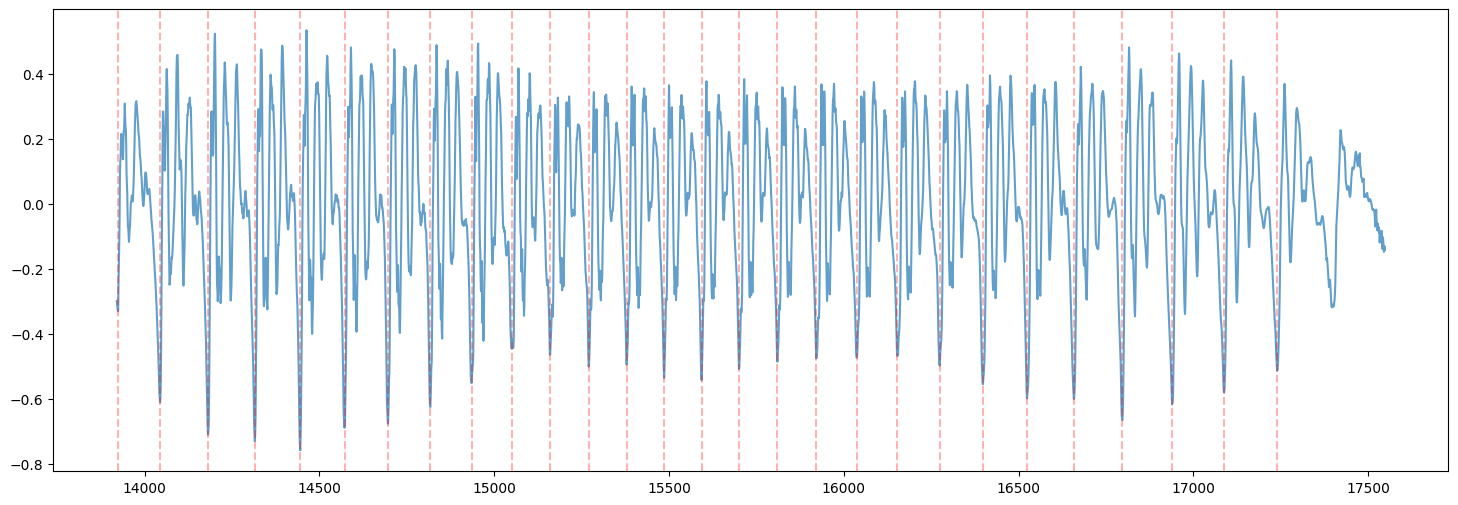

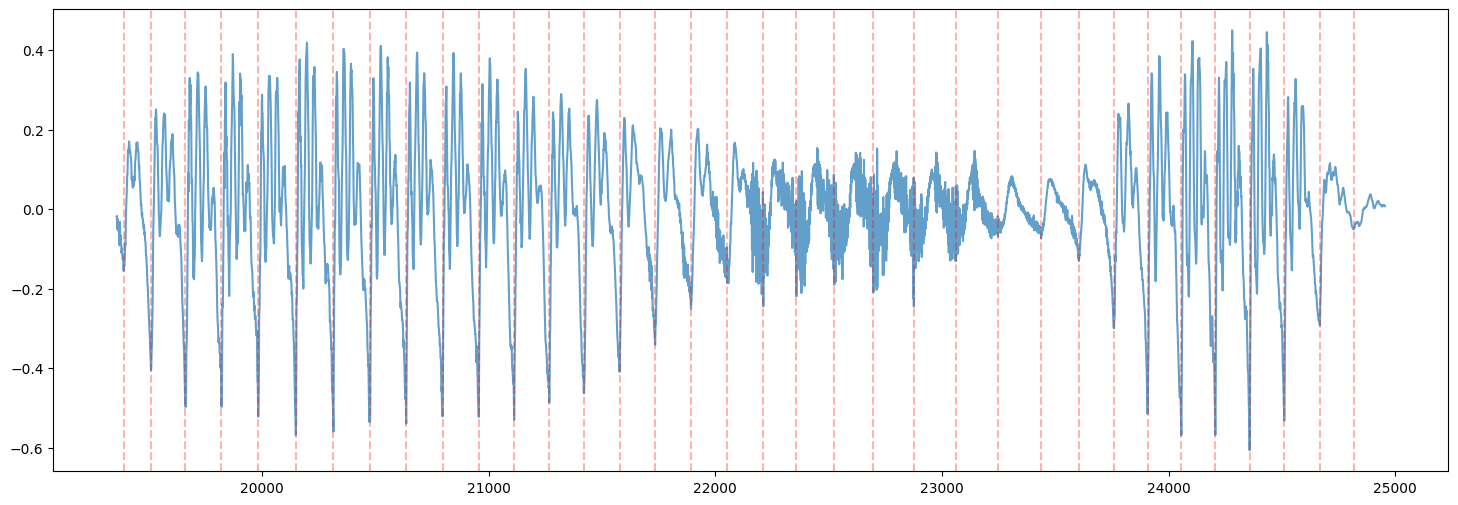

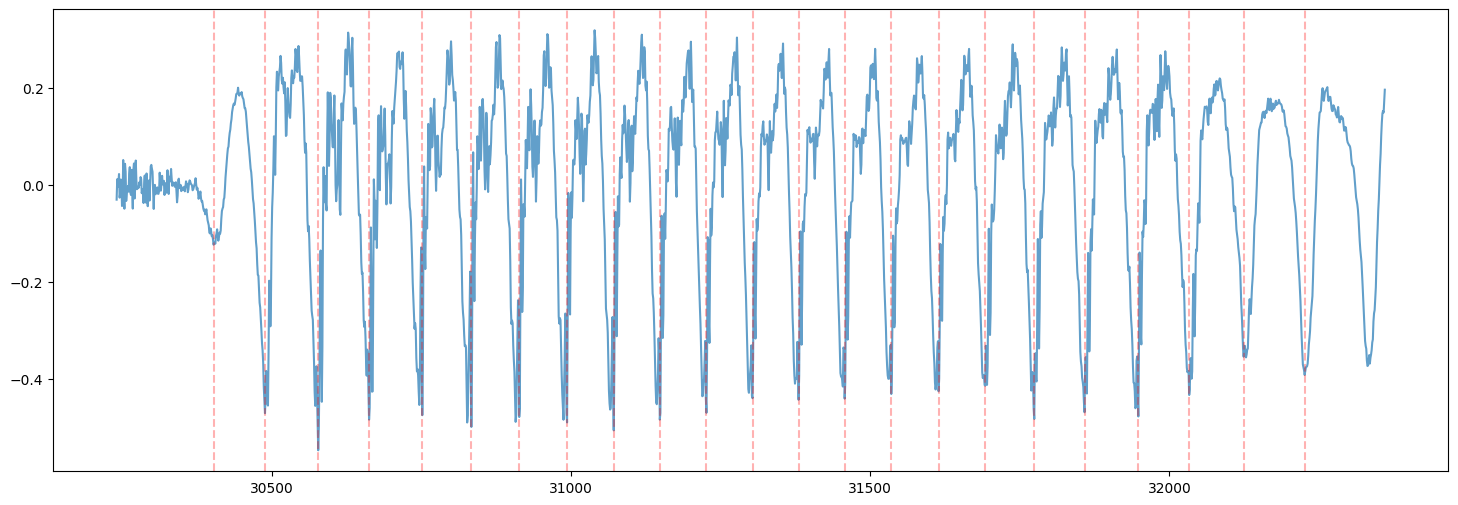

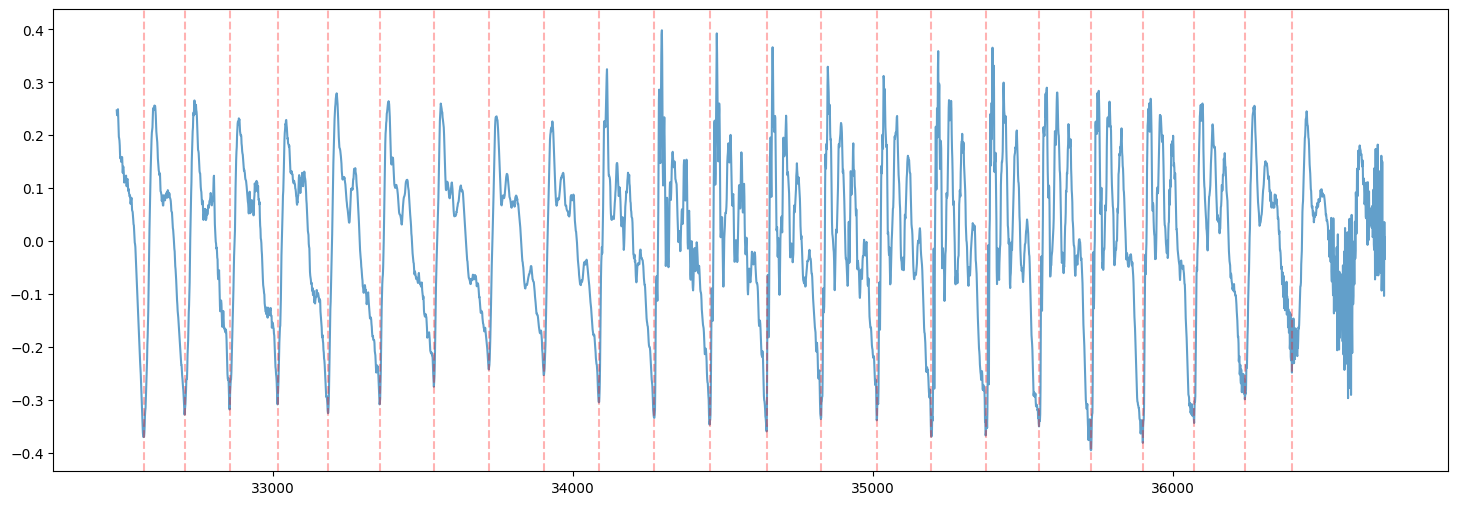

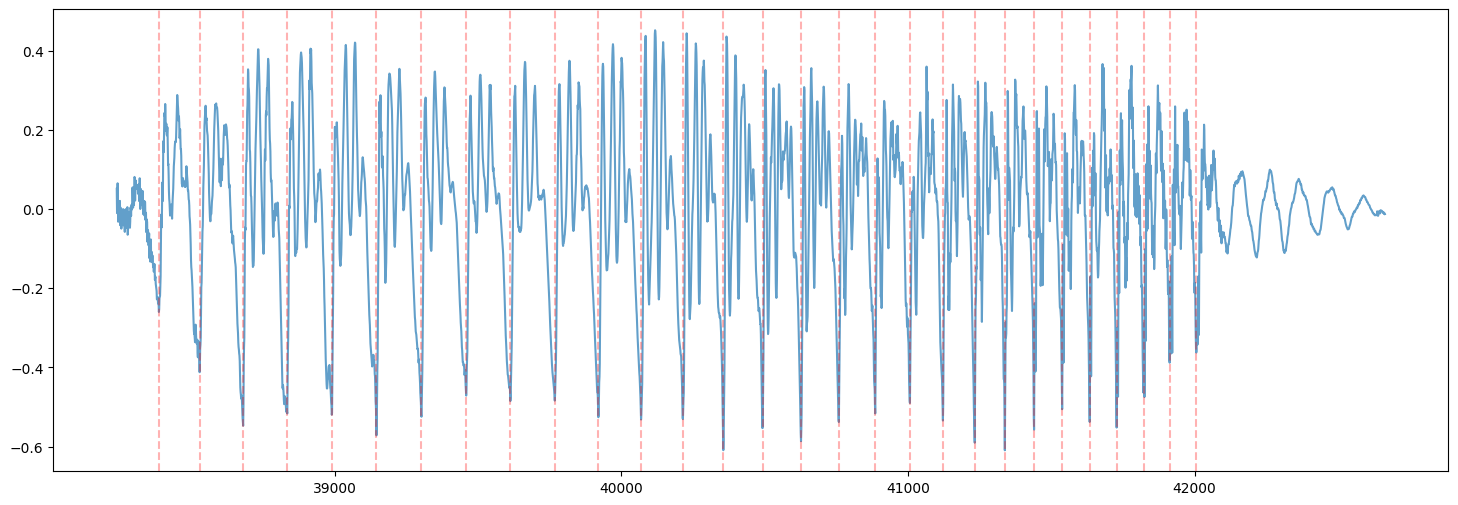

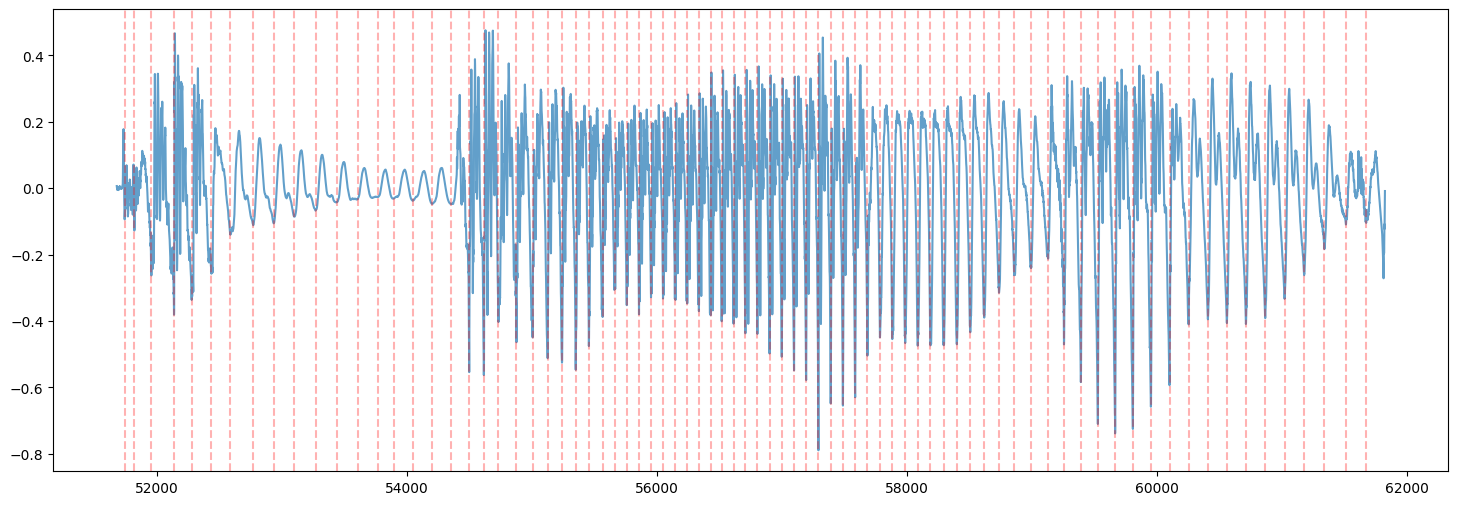

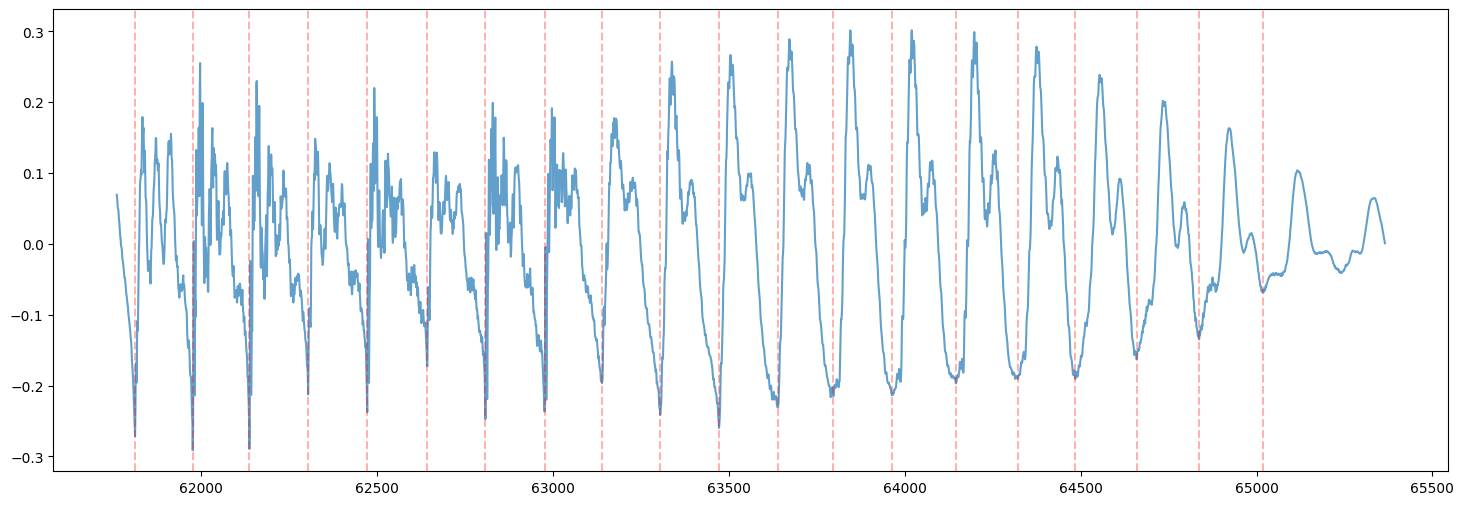

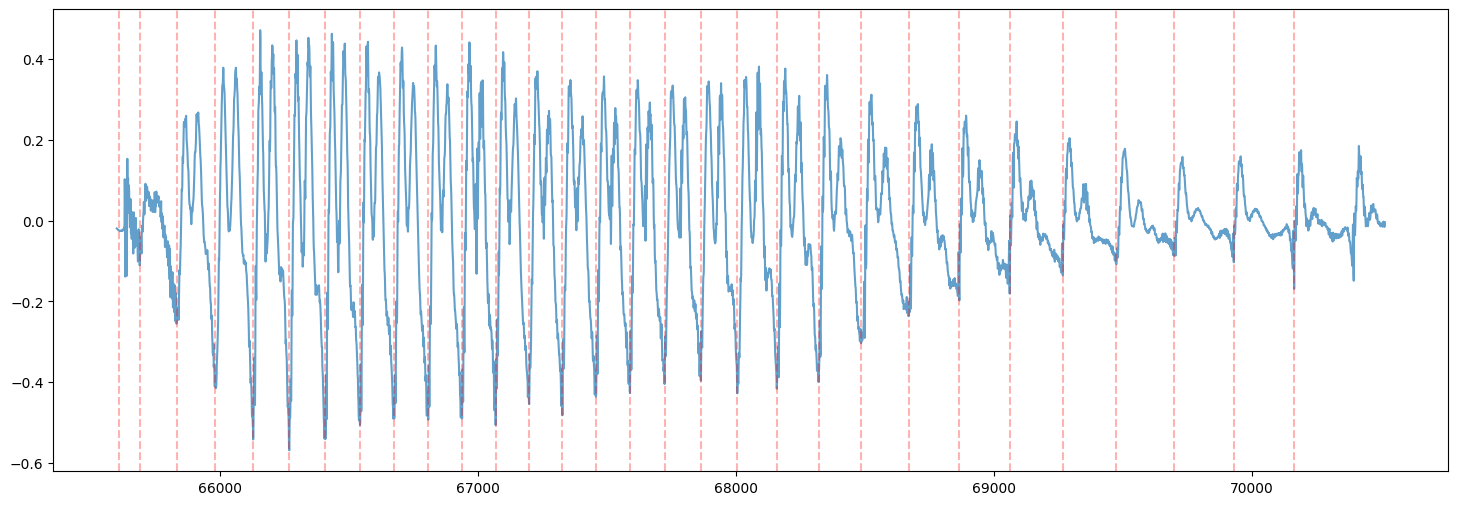

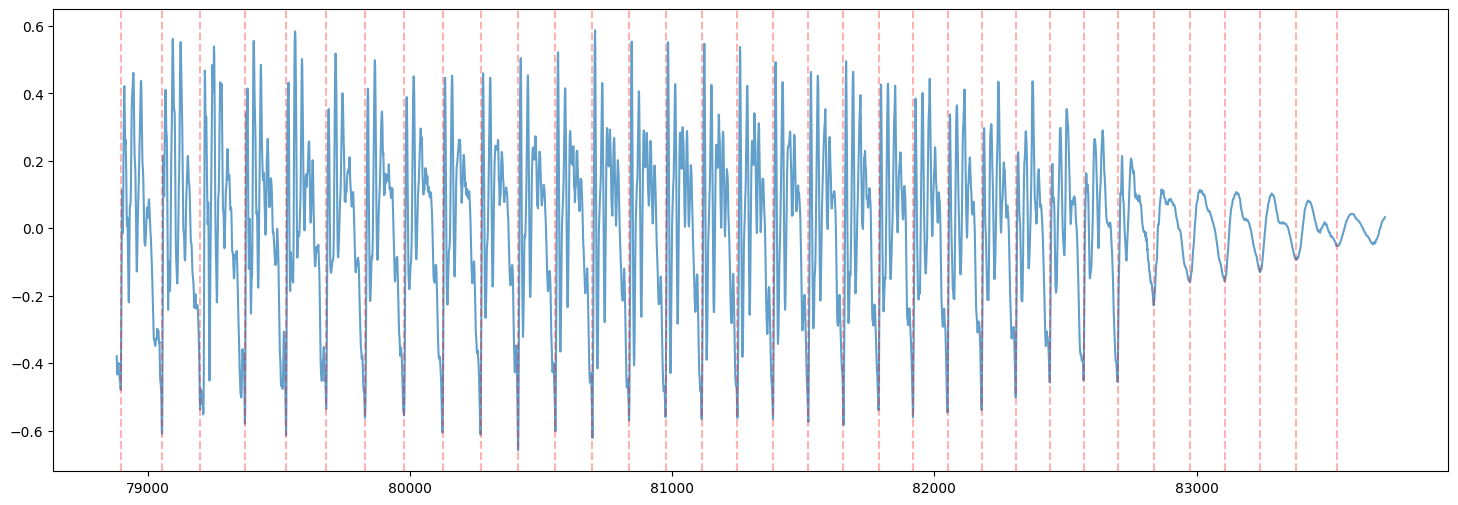

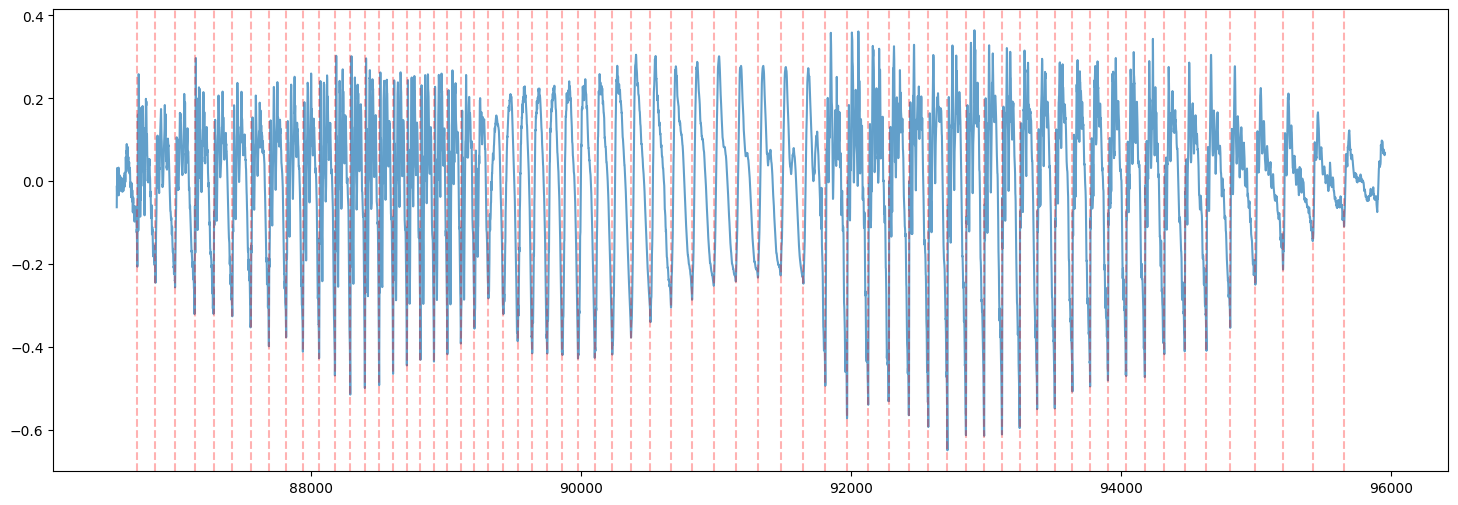

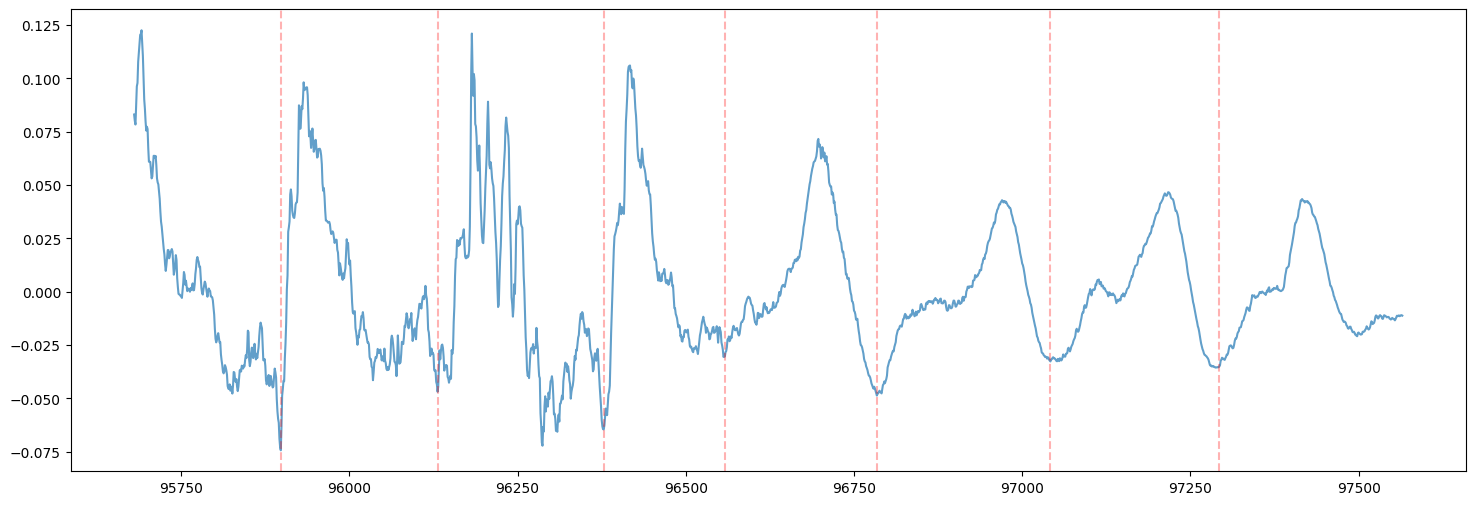

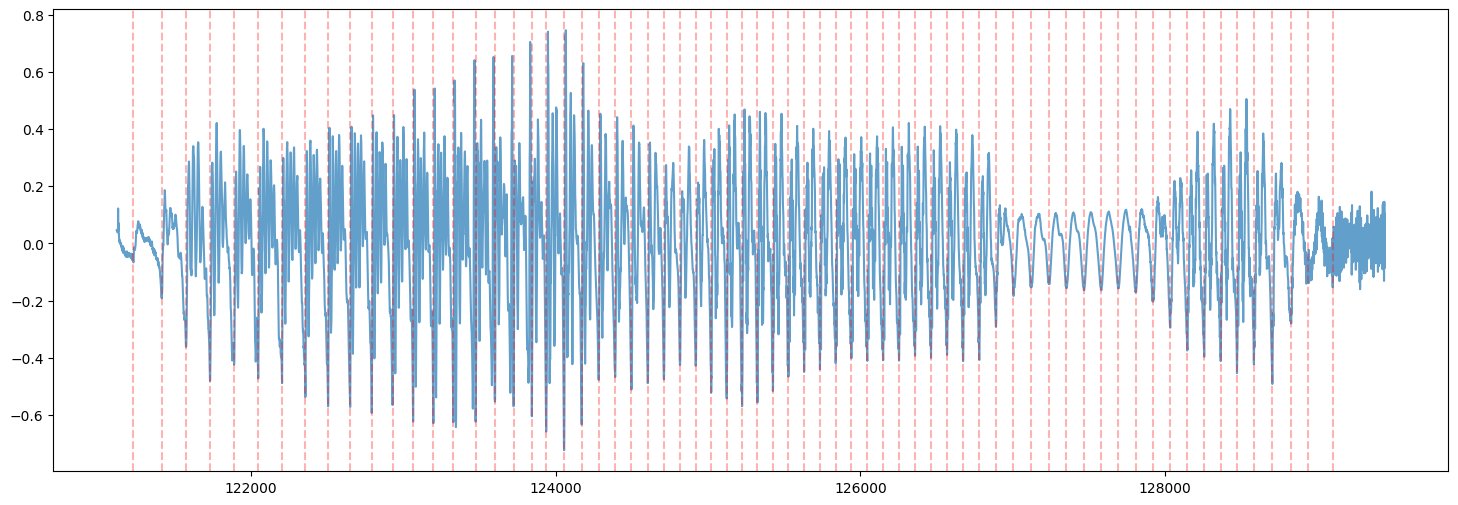

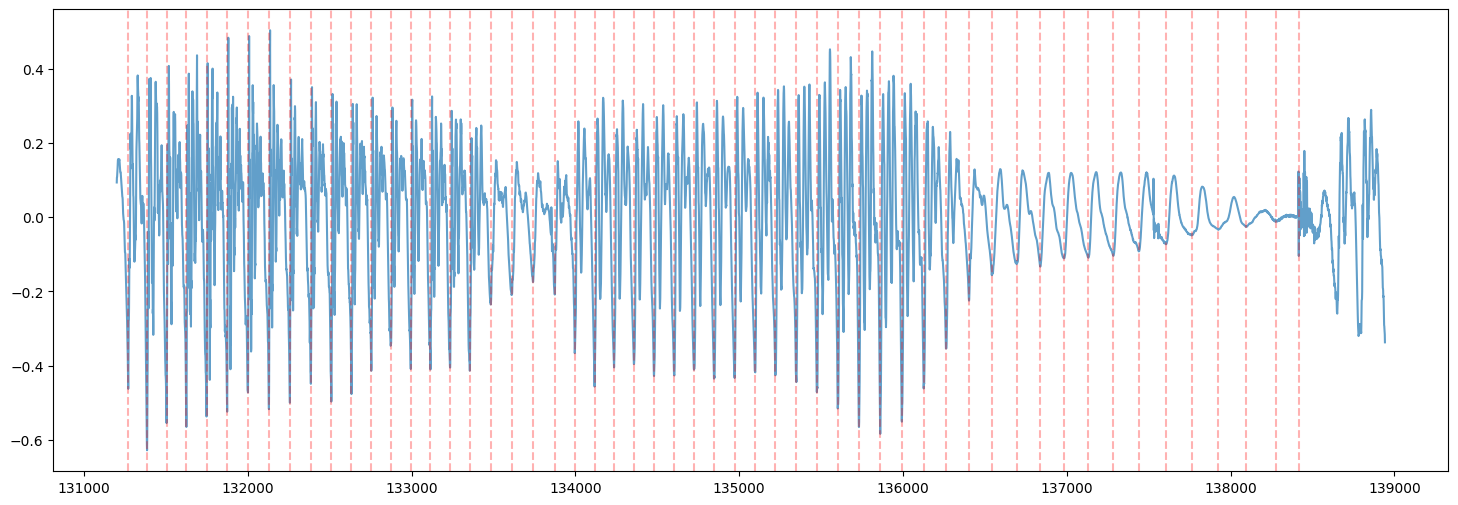

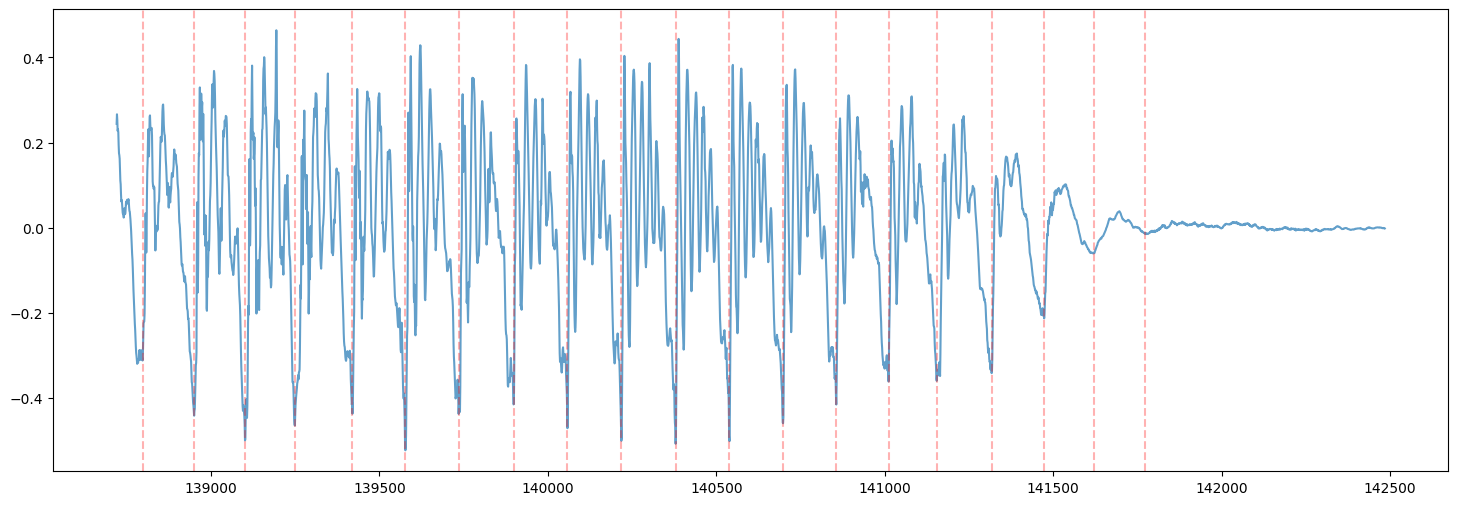

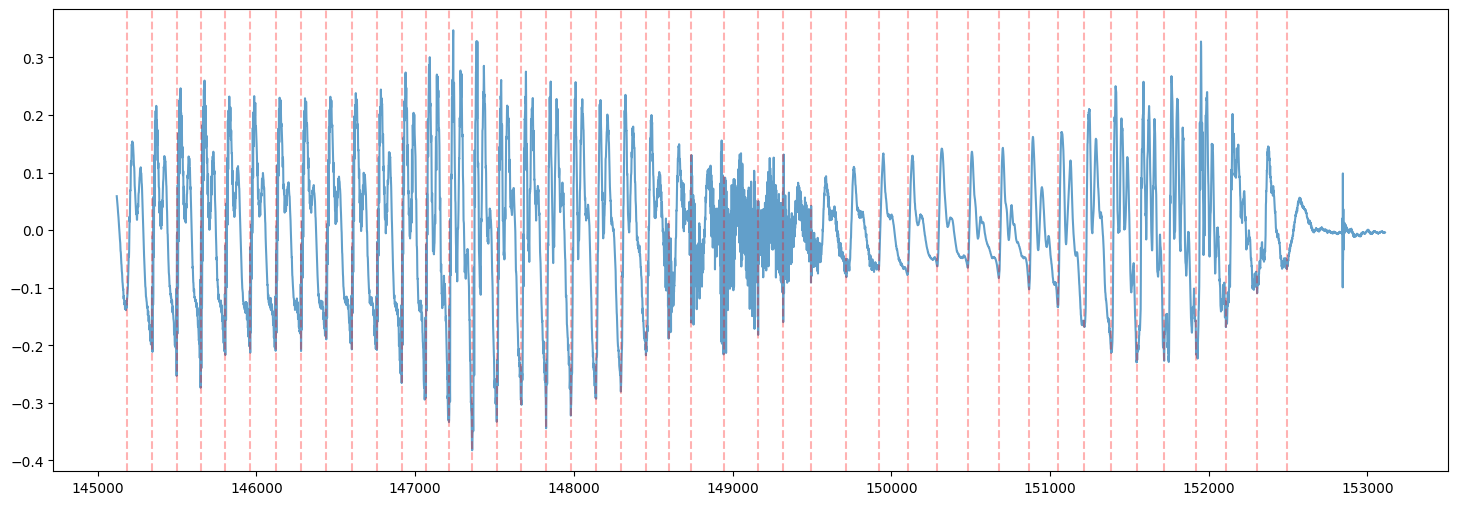

In [100]:
def mark_peaks(s, Fs, seq, mark1, mark2):
  marks = [mark1, mark2]
  search_range = int(fs*0.4)
  weight_window = (
    sg.windows.general_hamming(search_range*2, 0.7) +
    (sg.windows.kaiser_bessel_derived(search_range*2, np.pi*15)*0.8 + 0.2) +
    sg.windows.bartlett(search_range*2)
  )

  # 0th frame
  a_mark = mark1 - (mark2 - mark1)

  search_window = s[a_mark-search_range:a_mark+search_range]
  mark = int(a_mark + np.argmin(search_window) - search_range)

  marks.insert(0, mark)

  search_range = int(mark2 - mark1)
  weight_window = (
    sg.windows.general_hamming(search_range*2, 0.7) +
    (sg.windows.kaiser_bessel_derived(search_range*2, np.pi*15)*0.8 + 0.2) +
    sg.windows.bartlett(search_range*2)
  )

  last = 0
  while a_mark < int(f_start(seq[-1][0]) + seq[-1][0]):
    a_mark = marks[-1]  + (marks[-1] - marks[-2])
    if a_mark <= last:
      break
    last = a_mark

    search_window = s[a_mark-search_range:a_mark+search_range] * weight_window
    mark = int(a_mark + np.argmin(search_window) - (search_range))
    marks.append(mark)

  return [mark for mark in marks if f_start(seq[0][0]) < mark < f_start(seq[-1][0]) + seq[-1][0]][:-1]

for seq_i in range(len(seqs)):
  seq = seqs[seq_i]
  pitch_marks[seq_i] = mark_peaks(s, Fs, seq, pitch_marks[seq_i][1], pitch_marks[seq_i][2])

  if PLOT:
    plt.figure(figsize=(18,6))
    zoom_s = f_start(seq[0][0])
    zoom_e = f_start(seq[-1][0]) + seq[-1][0]
    zoom = np.arange(zoom_s, zoom_e)
    plt.plot(zoom, s[zoom_s:zoom_e], alpha=0.7)

    for i in range(len(pitch_marks[seq_i])):
      if pitch_marks[seq_i][i] == 0:
        continue
      plt.axvline(pitch_marks[seq_i][i], color='r', linestyle='--', alpha=0.3)

    plt.show()

In [123]:
ps_seq_frames = []

for i, marks in enumerate(pitch_marks):
  ps_frames = []
  for j, mark in enumerate(marks):
    if j == 0:
      pfl = marks[1] - marks[0]
    elif j < len(marks) - 2:
      pfl = min(marks[j] - marks[j-1], marks[j+1] - marks[j])
    else:
      pfl = marks[-1] - marks[-2]
    pfl = pfl // 2 * 2
    f = s[mark-pfl:mark+pfl] * np.hanning(pfl*2)
    ps_frames.append({"center":mark, "fl":pfl, "sig":f})
  ps_seq_frames.append(ps_frames)


  if PLOT:
    zoom_s = marks[0] - (marks[1] - marks[0])
    zoom_e = marks[-1] + (marks[-1] - marks[-2])
    zoom = np.arange(zoom_s, zoom_e)
    plt.figure(figsize=(18,6))
    plt.title(f"Voiced sequence[{i}]")
    plt.plot(zoom, s[zoom_s:zoom_e], alpha=0.7)

    for mark in ps_frames:
      plt.axvline(mark["center"], color='r', linestyle='--', alpha=0.3)
      base = np.arange(mark["center"]-mark["fl"], mark["center"]+mark["fl"])
      plt.plot(base, np.hanning(mark["fl"]*2), '--', color='m', alpha=0.7)
    plt.show()

120 64 -56
193 64 -129
263 64 -199
new
199 64 -135
new
135 64 -71
201 64 -137
new
137 64 -73
200 64 -136
new
136 64 -72
196 64 -132
new
132 64 -68
189 64 -125
new
125 64 -61
179 64 -115
new
115 64 -51
166 64 -102
212 64 -148
new
148 64 -84
194 64 -130
new
130 64 -66
175 64 -111
new
111 64 -47
154 64 -90
197 64 -133
new
133 64 -69
176 64 -112
new
112 64 -48
158 64 -94
205 64 -141
new
141 64 -77
193 64 -129
new
129 64 -65
181 64 -117
new
117 64 -53
174 64 -110
234 64 -170
new
170 64 -106
232 64 -168
new
168 64 -104
238 64 -174
new
174 64 -110
249 64 -185
new
185 64 -121
263 64 -199
new
199 64 -135
284 64 -220
new
220 64 -156
new
156 64 -92


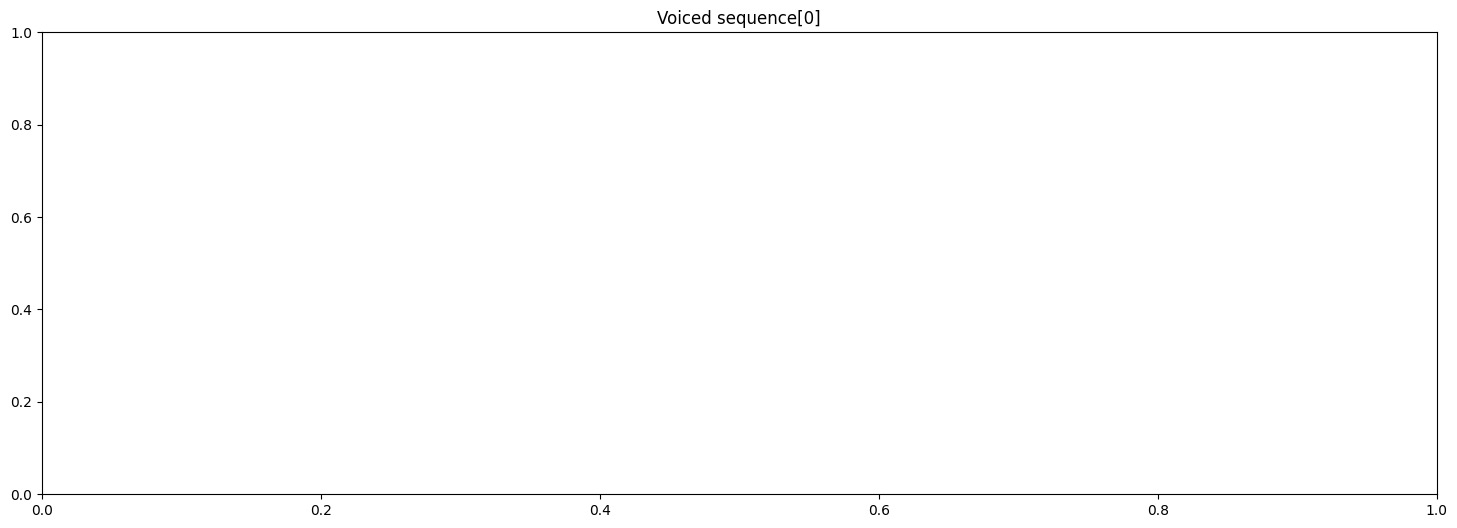

121 57 -64
215 57 -158
new
158 57 -101
261 57 -204
new
204 57 -147
309 57 -252
new
252 57 -195
new
195 57 -138
304 57 -247
new
247 57 -190
new
190 57 -133
299 57 -242
new
242 57 -185
new
185 57 -128
289 57 -232
new
232 57 -175
new
175 57 -118
278 57 -221
new
221 57 -164
new
164 57 -107
267 57 -210
new
210 57 -153
313 57 -256
new
256 57 -199
new
199 57 -142
298 57 -241
new
241 57 -184
new
184 57 -127
282 57 -225
new
225 57 -168
new
168 57 -111
264 57 -207
new
207 57 -150
307 57 -250
new
250 57 -193
new
193 57 -136
293 57 -236
new
236 57 -179
new
179 57 -122
280 57 -223
new
223 57 -166
new
166 57 -109
268 57 -211
new
211 57 -154
314 57 -257
new
257 57 -200
new
200 57 -143
289 57 -232
new
232 57 -175
new
175 57 -118
285 57 -228
new
228 57 -171
new
171 57 -114
287 57 -230
new
230 57 -173
new
173 57 -116
294 57 -237
new
237 57 -180
new
180 57 -123
309 57 -252
new
252 57 -195
new
195 57 -138
323 57 -266
new
266 57 -209
new
209 57 -152
342 57 -285
new
285 57 -228
new
228 57 -171
new
171 57 -1

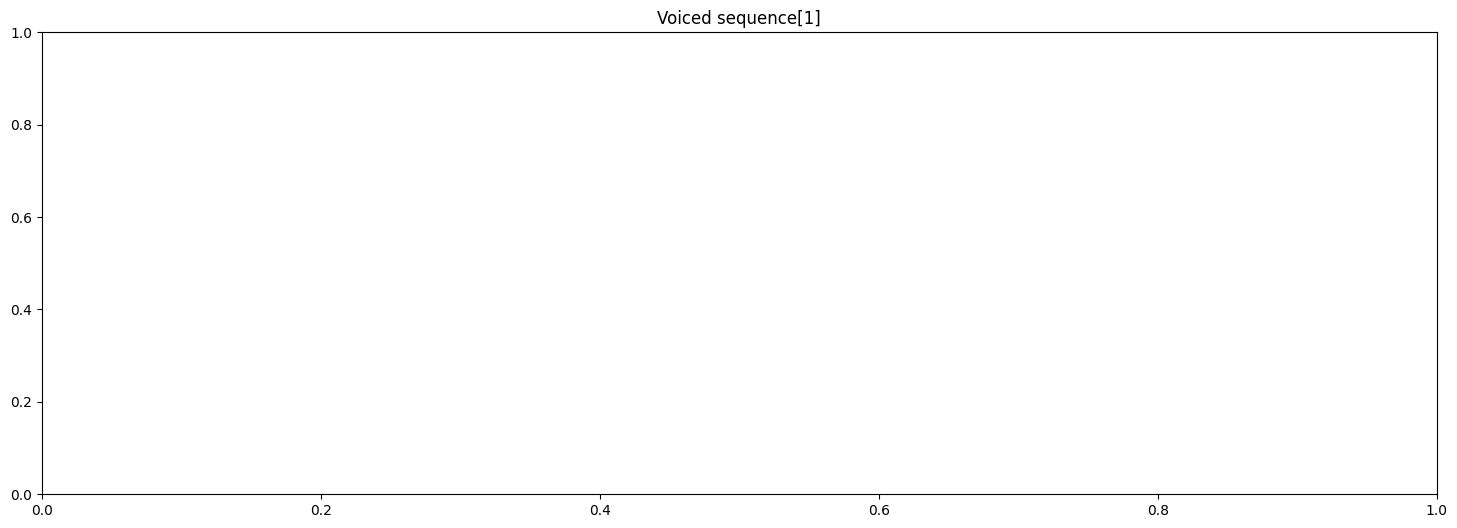

86 68 -18
107 68 -39
124 68 -56
145 68 -77
159 68 -91
new
91 68 -23
103 68 -35
115 68 -47
125 68 -57
134 68 -66
144 68 -76
153 68 -85
new
85 68 -17
94 68 -26
103 68 -35
113 68 -45
124 68 -56
134 68 -66
148 68 -80
164 68 -96
new
96 68 -28
118 68 -50
135 77 -58
149 77 -72


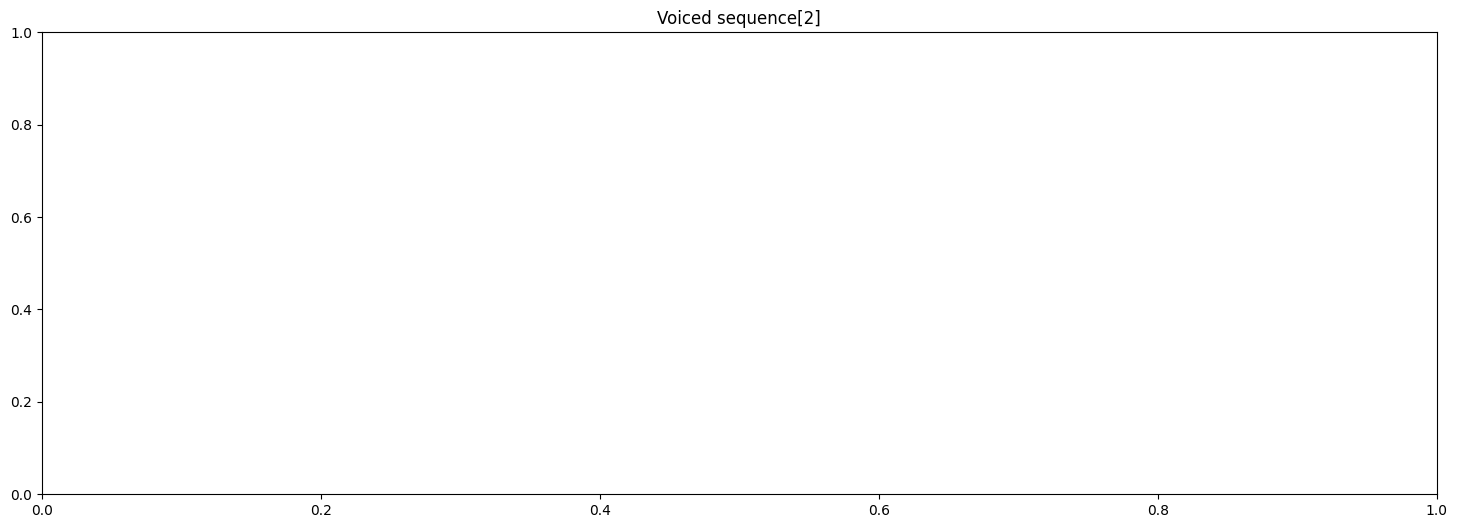

135 77 -58
208 77 -131
291 77 -214
new
214 77 -137
305 77 -228
new
228 77 -151
323 77 -246
new
246 77 -169
350 77 -273
new
273 77 -196
new
196 77 -119
302 77 -225
new
225 77 -148
331 77 -254
new
254 77 -177
361 77 -284
new
284 77 -207
new
207 77 -130
314 77 -237
new
237 77 -160
345 77 -268
new
268 77 -191
new
191 77 -114
304 77 -227
new
227 77 -150
331 77 -254
new
254 77 -177
363 77 -286
new
286 77 -209
new
209 77 -132
314 77 -237
new
237 77 -160
341 77 -264
new
264 77 -187
new
187 77 -110
288 77 -211
new
211 77 -134
308 77 -231
new
231 77 -154
326 77 -249
new
249 77 -172
new
172 77 -95
266 77 -189
new
189 77 -112
281 77 -204
new
204 77 -127


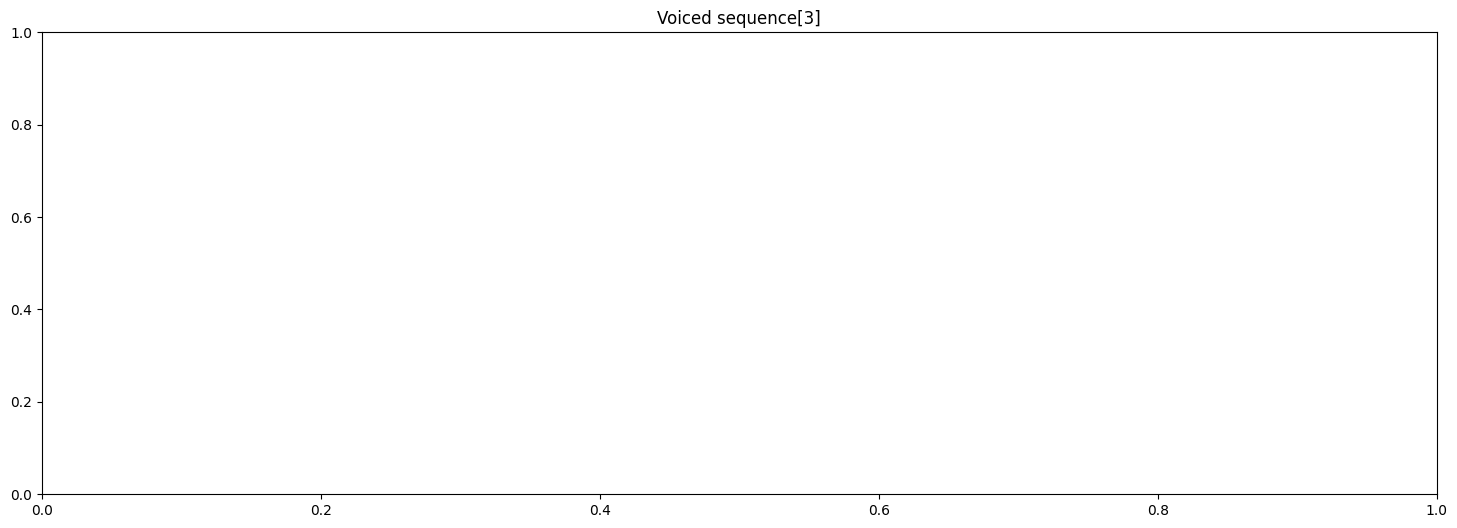

142 68 -74
226 68 -158
new
158 68 -90
244 68 -176
new
176 68 -108
263 68 -195
new
195 68 -127
283 68 -215
new
215 68 -147
304 68 -236
new
236 68 -168
new
168 68 -100
256 68 -188
new
188 68 -120
274 68 -206
new
206 68 -138
293 68 -225
new
225 68 -157
new
157 68 -89
241 68 -173
new
173 68 -105
254 68 -186
new
186 68 -118
264 68 -196
new
196 68 -128
269 68 -201
new
201 68 -133
270 68 -202
new
202 68 -134
268 68 -200
new
200 68 -132
264 68 -196
new
196 68 -128
new
128 68 -60
187 68 -119
240 68 -172
new
172 68 -104
219 68 -151
new
151 68 -83
194 68 -126
new
126 68 -58
163 68 -95
197 68 -129
new
129 68 -61
159 68 -91
187 68 -119
new
119 68 -51
145 68 -77
174 68 -106
new
106 68 -38
126 68 -58


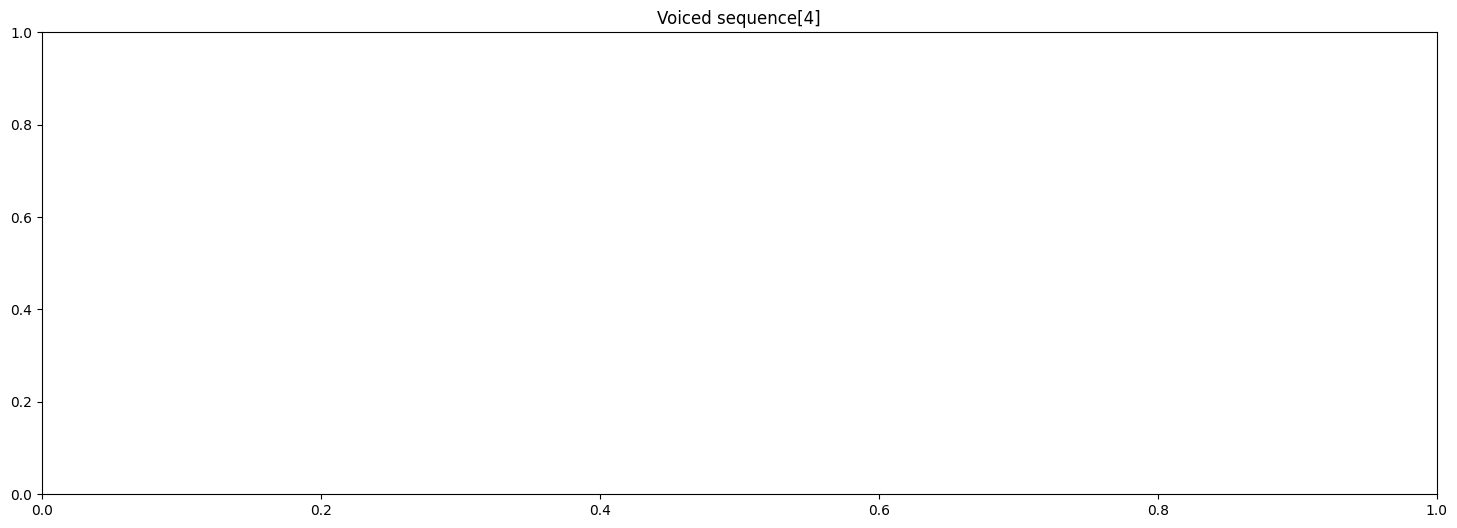

78 64 -14
150 64 -86
267 64 -203
new
203 64 -139
280 64 -216
new
216 64 -152
new
152 64 -88
246 64 -182
new
182 64 -118
270 64 -206
new
206 64 -142
325 64 -261
new
261 64 -197
new
197 64 -133
297 64 -233
new
233 64 -169
new
169 64 -105
269 64 -205
new
205 64 -141
311 64 -247
new
247 64 -183
new
183 64 -119
289 64 -225
new
225 64 -161
327 64 -263
new
263 64 -199
new
199 64 -135
297 64 -233
new
233 64 -169
new
169 64 -105
233 64 -169
new
169 64 -105
255 64 -191
new
191 64 -127
281 64 -217
new
217 64 -153
307 64 -243
new
243 64 -179
new
179 64 -115
260 64 -196
new
196 64 -132
new
132 64 -68
185 64 -121
new
121 64 -57
174 64 -110
254 64 -190
new
190 64 -126
255 64 -191
new
191 64 -127
new
127 64 -63
183 64 -119
new
119 64 -55
170 64 -106
216 64 -152
new
152 64 -88
193 64 -129
new
129 64 -65
175 64 -111
new
111 64 -47
148 64 -84
176 64 -112
new
112 64 -48
146 64 -82
178 64 -114
new
114 64 -50
146 64 -82
177 64 -113
new
113 64 -49
148 64 -84
177 64 -113
new
113 64 -49
143 64 -79
167 64 -103


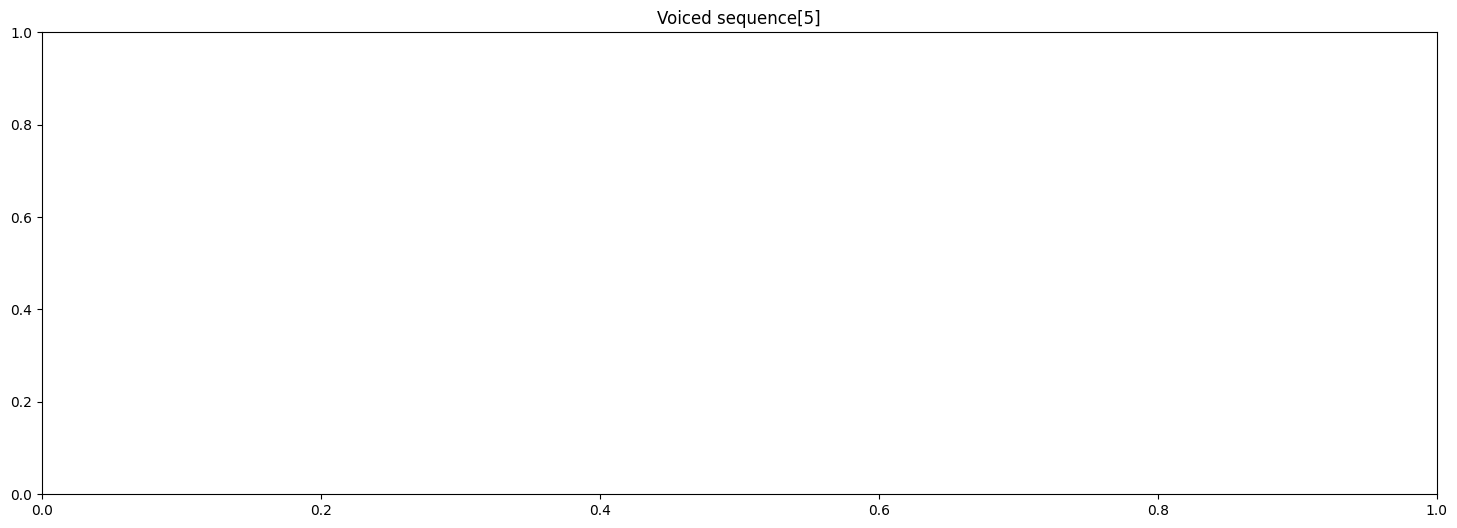

164 54 -110
271 54 -217
new
217 54 -163
new
163 54 -109
276 54 -222
new
222 54 -168
new
168 54 -114
282 54 -228
new
228 54 -174
new
174 54 -120
290 54 -236
new
236 54 -182
new
182 54 -128
294 54 -240
new
240 54 -186
new
186 54 -132
300 54 -246
new
246 54 -192
new
192 54 -138
301 54 -247
new
247 54 -193
new
193 54 -139
305 54 -251
new
251 54 -197
new
197 54 -143
310 54 -256
new
256 54 -202
new
202 54 -148
316 54 -262
new
262 54 -208
new
208 54 -154
311 54 -257
new
257 54 -203
new
203 54 -149
315 54 -261
new
261 54 -207
new
207 54 -153
335 64 -271
new
271 64 -207
new
207 64 -143
319 64 -255
new
255 64 -191
new
191 64 -127
291 64 -227
new
227 64 -163
337 64 -273
new
273 64 -209
new
209 64 -145
323 64 -259
new
259 64 -195
new
195 64 -131


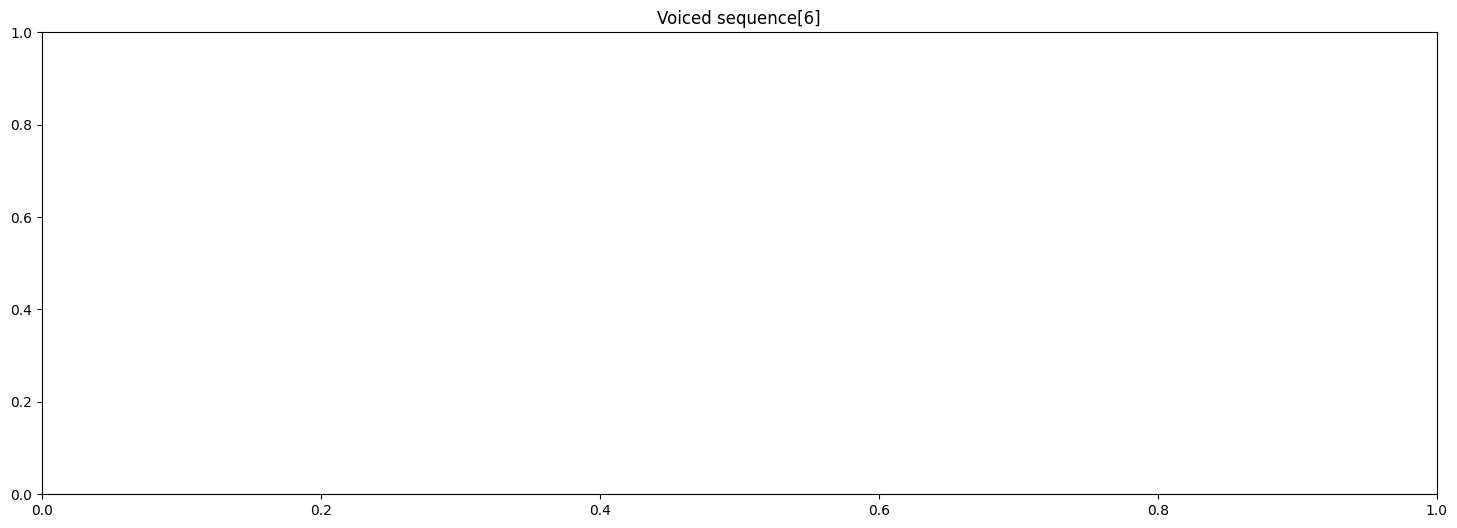

80 64 -16
159 64 -95
243 64 -179
new
179 64 -115
264 64 -200
new
200 64 -136
276 64 -212
new
212 64 -148
new
148 64 -84
224 64 -160
new
160 64 -96
230 64 -166
new
166 64 -102
235 64 -171
new
171 64 -107
239 64 -175
new
175 64 -111
242 64 -178
new
178 64 -114
244 64 -180
new
180 64 -116
246 64 -182
new
182 64 -118
247 64 -183
new
183 64 -119
249 64 -185
new
185 64 -121
253 64 -189
new
189 64 -125
259 64 -195
new
195 64 -131
272 64 -208
new
208 64 -144
new
144 64 -80
221 64 -157
new
157 64 -93
246 64 -182
new
182 64 -118
280 64 -216
new
216 64 -152
317 64 -253
new
253 64 -189
new
189 64 -125
309 64 -245
new
245 64 -181
378 64 -314
new
314 64 -250
new
250 64 -186
381 64 -317
new
317 64 -253
new
253 64 -189
395 64 -331
new
331 64 -267
new
267 64 -203
411 64 -347
new
347 64 -283
new
283 64 -219
new
219 64 -155
379 64 -315
new
315 64 -251
new
251 64 -187
418 64 -354
new
354 64 -290
new
290 64 -226


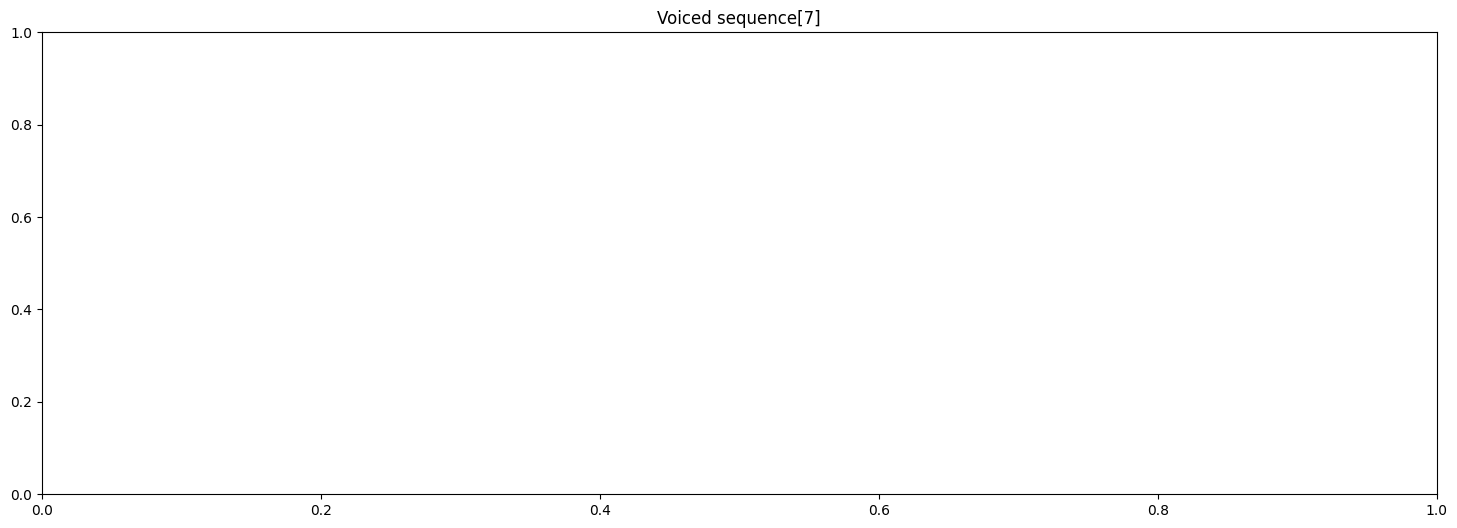

157 68 -89
235 68 -167
new
167 68 -99
270 68 -202
new
202 68 -134
291 68 -223
new
223 68 -155
new
155 68 -87
240 68 -172
new
172 68 -104
252 68 -184
new
184 68 -116
265 68 -197
new
197 68 -129
276 68 -208
new
208 68 -140
285 68 -217
new
217 68 -149
new
149 68 -81
224 68 -156
new
156 68 -88
231 68 -163
new
163 68 -95
236 68 -168
new
168 68 -100
240 68 -172
new
172 68 -104
243 68 -175
new
175 68 -107
245 68 -177
new
177 68 -109
245 68 -177
new
177 68 -109
245 68 -177
new
177 68 -109
244 68 -176
new
176 68 -108
242 68 -174
new
174 68 -106
240 68 -172
new
172 68 -104
235 68 -167
new
167 68 -99
231 68 -163
new
163 68 -95
225 68 -157
new
157 68 -89
219 68 -151
new
151 68 -83
213 68 -145
new
145 68 -77
206 68 -138
new
138 68 -70
200 68 -132
new
132 68 -64
201 68 -133
272 68 -204
new
204 68 -136
new
136 68 -68
201 68 -133
new
133 68 -65
199 77 -122
258 77 -181
new
181 77 -104


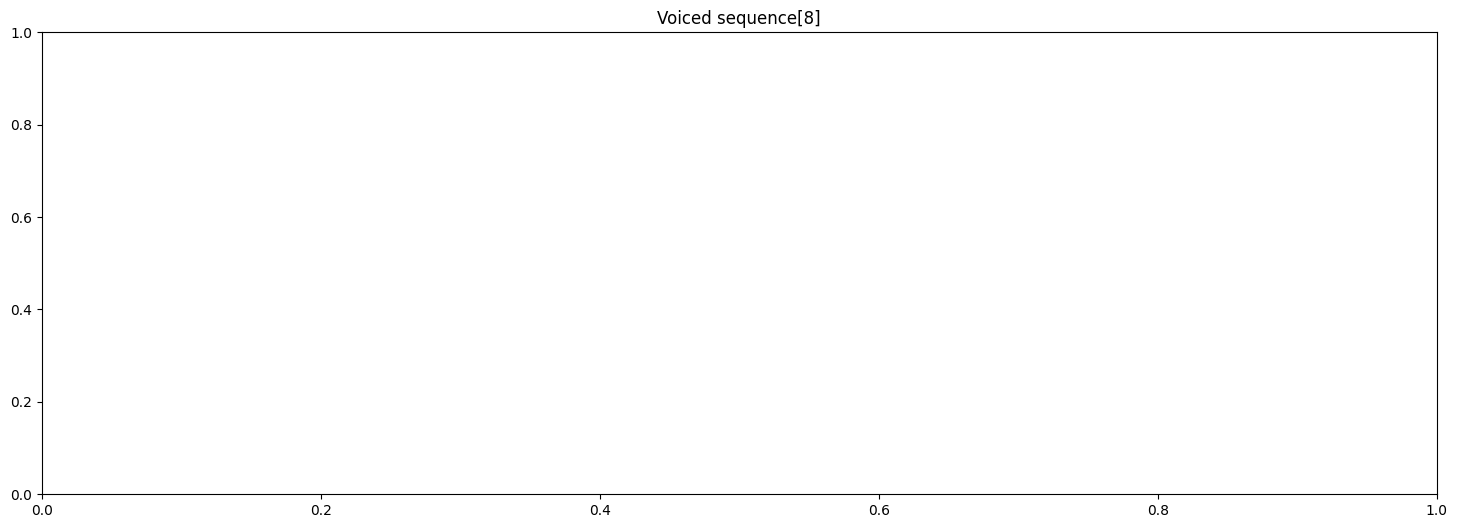

134 77 -57
202 77 -125
269 77 -192
new
192 77 -115
256 77 -179
new
179 77 -102
241 77 -164
new
164 77 -87
222 77 -145
new
145 77 -68
204 77 -127
255 77 -178
new
178 77 -101
225 77 -148
new
148 77 -71
191 77 -114
231 77 -154
new
154 77 -77
191 77 -114
new
114 77 -37
145 77 -68
174 77 -97
200 77 -123
new
123 77 -46
148 77 -71
172 77 -95
195 77 -118
new
118 77 -41
141 77 -64
163 77 -86
187 77 -110
new
110 77 -33
136 77 -59
170 77 -93
199 77 -122
new
122 77 -45
153 68 -85
196 68 -128
new
128 68 -60
173 68 -105
220 68 -152
new
152 68 -84
208 68 -140
new
140 68 -72
202 68 -134
new
134 68 -66
205 68 -137
281 68 -213
new
213 68 -145
new
145 68 -77
229 68 -161
new
161 68 -93
249 68 -181
new
181 68 -113
274 68 -206
new
206 68 -138
301 68 -233
new
233 68 -165
new
165 68 -97
261 68 -193
new
193 68 -125
293 68 -225
new
225 68 -157
326 68 -258
new
258 68 -190
new
190 68 -122
284 68 -216
new
216 68 -148
309 68 -241
new
241 68 -173
new
173 68 -105
262 68 -194
new
194 68 -126
278 68 -210
new
210 68 -14

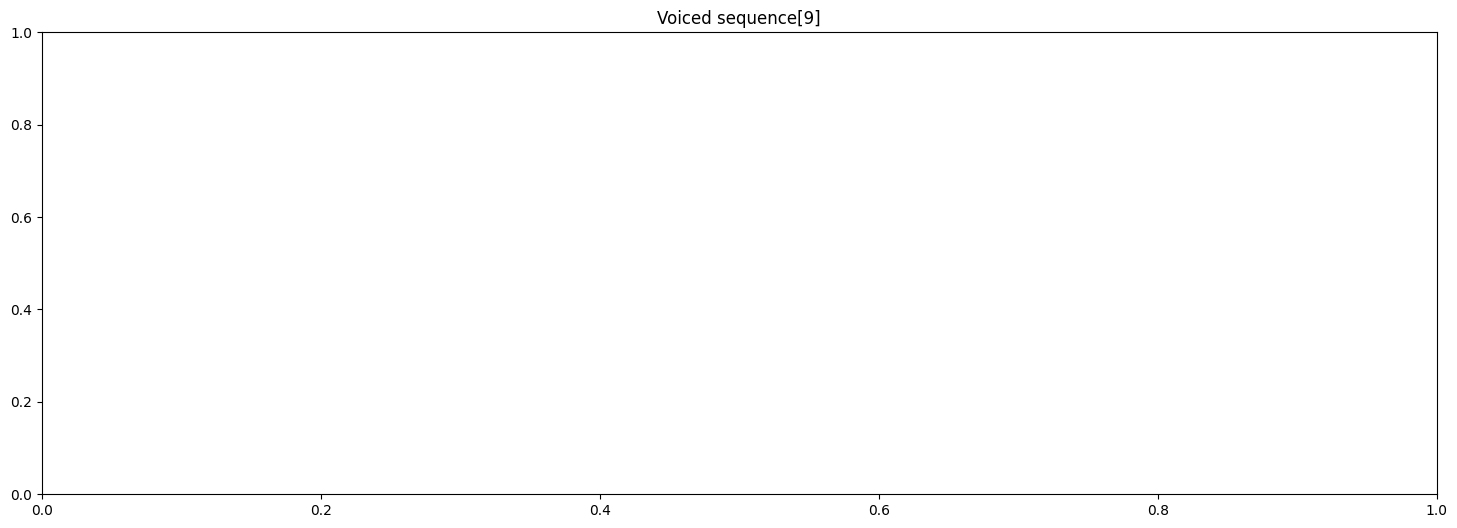

233 54 -179
426 54 -372
new
372 54 -318
new
318 54 -264
new
264 54 -210
new
210 54 -156
336 54 -282
new
282 54 -228
new
228 54 -174
400 54 -346
new
346 54 -292
new
292 54 -238
new
238 54 -184
442 54 -388
new
388 54 -334
new
334 54 -280
new
280 54 -226


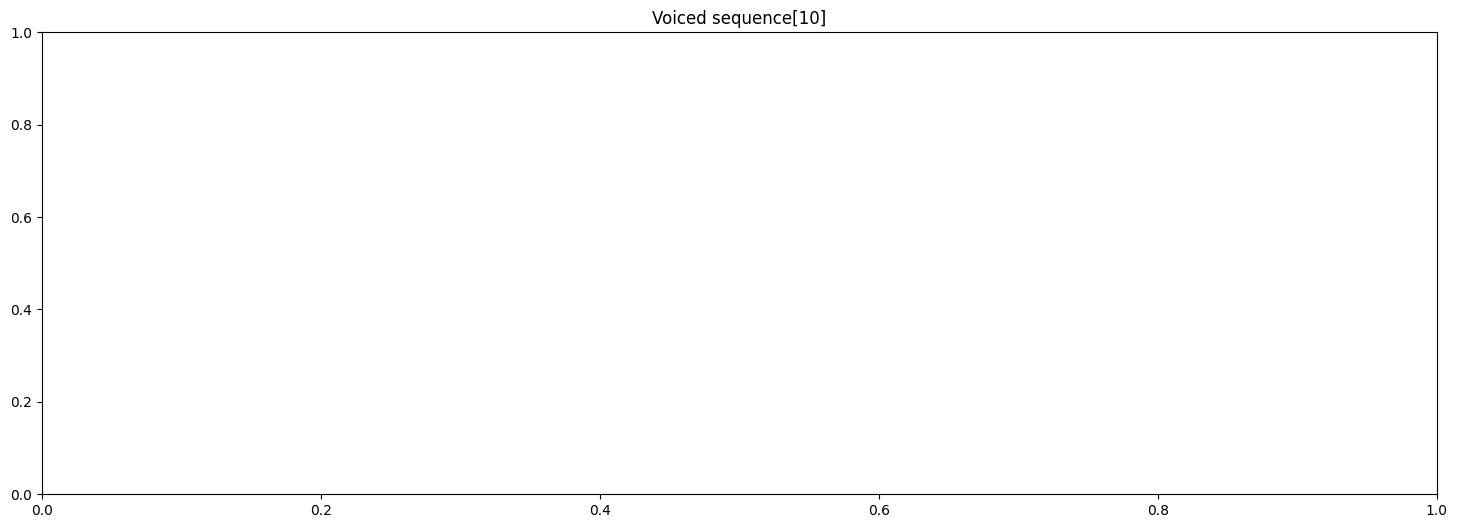

185 64 -121
282 64 -218
new
218 64 -154
311 57 -254
new
254 57 -197
new
197 57 -140
298 57 -241
new
241 57 -184
new
184 57 -127
285 57 -228
new
228 57 -171
new
171 57 -114
271 57 -214
new
214 57 -157
new
157 57 -100
253 57 -196
new
196 57 -139
288 57 -231
new
231 57 -174
new
174 57 -117
262 57 -205
new
205 57 -148
new
148 57 -91
232 57 -175
new
175 57 -118
255 57 -198
new
198 57 -141
new
141 57 -84
219 57 -162
new
162 57 -105
238 57 -181
new
181 57 -124
255 57 -198
new
198 57 -141
new
141 57 -84
230 57 -173
new
173 57 -116
243 57 -186
new
186 57 -129
new
129 57 -72
195 57 -138
new
138 57 -81
200 57 -143
new
143 57 -86
180 57 -123
new
123 57 -66
184 57 -127
new
127 57 -70
185 57 -128
new
128 57 -71
183 57 -126
new
126 57 -69
177 57 -120
new
120 57 -63
170 57 -113
new
113 57 -56
163 57 -106
212 57 -155
new
155 57 -98
203 57 -146
new
146 57 -89
192 57 -135
new
135 57 -78
180 57 -123
new
123 57 -66
168 57 -111
new
111 57 -54
155 57 -98
199 57 -142
new
142 57 -85
186 57 -129
new
129 57 -72


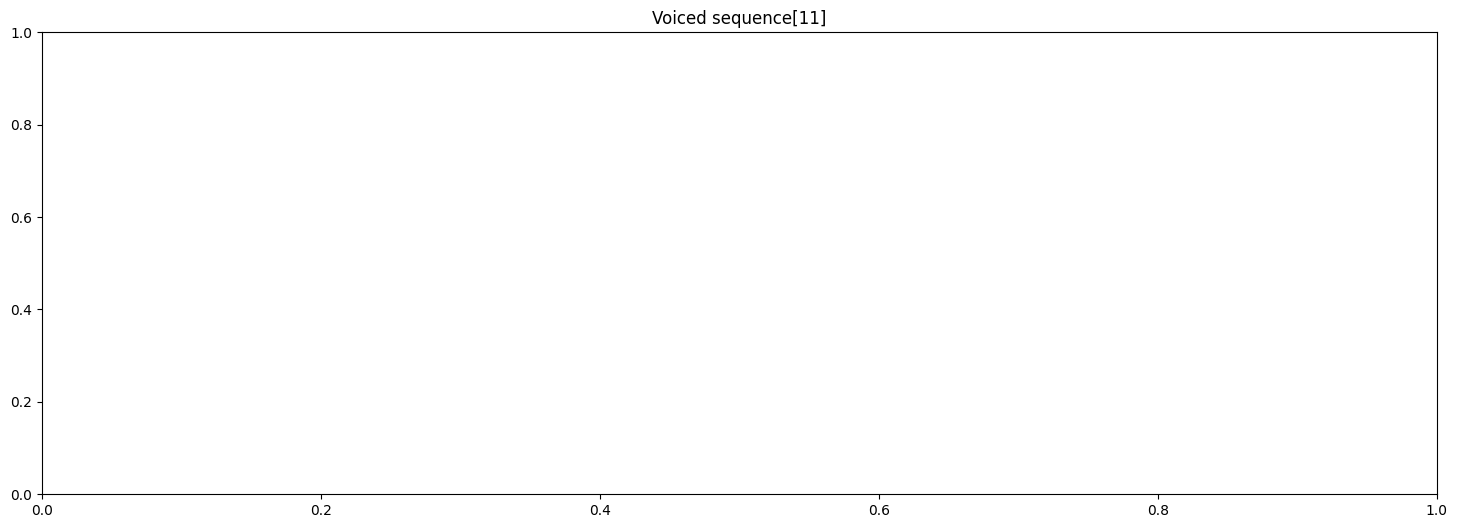

115 68 -47
166 68 -98
219 68 -151
new
151 68 -83
206 68 -138
new
138 68 -70
196 68 -128
new
128 68 -60
187 68 -119
247 68 -179
new
179 68 -111
239 68 -171
new
171 68 -103
231 68 -163
new
163 68 -95
220 68 -152
new
152 68 -84
207 68 -139
new
139 68 -71
192 68 -124
new
124 68 -56
175 68 -107
229 68 -161
new
161 68 -93
213 68 -145
new
145 68 -77
197 68 -129
new
129 68 -61
181 68 -113
241 68 -173
new
173 68 -105
232 68 -164
new
164 68 -96
227 68 -159
new
159 68 -91
224 68 -156
new
156 68 -88
210 68 -142
new
142 68 -74
195 68 -127
new
127 68 -59
178 68 -110
231 68 -163
new
163 68 -95
218 77 -141
new
141 77 -64
188 77 -111
231 77 -154
new
154 77 -77
199 77 -122
248 77 -171
new
171 77 -94
220 77 -143
new
143 77 -66
189 77 -112
240 77 -163
new
163 77 -86
211 77 -134
new
134 77 -57
184 77 -107
237 77 -160
new
160 77 -83
213 77 -136
new
136 77 -59
191 77 -114
247 77 -170
new
170 77 -93
229 77 -152
new
152 77 -75
216 77 -139
new
139 77 -62
201 77 -124
275 77 -198
new
198 77 -121
266 77 -189
new
1

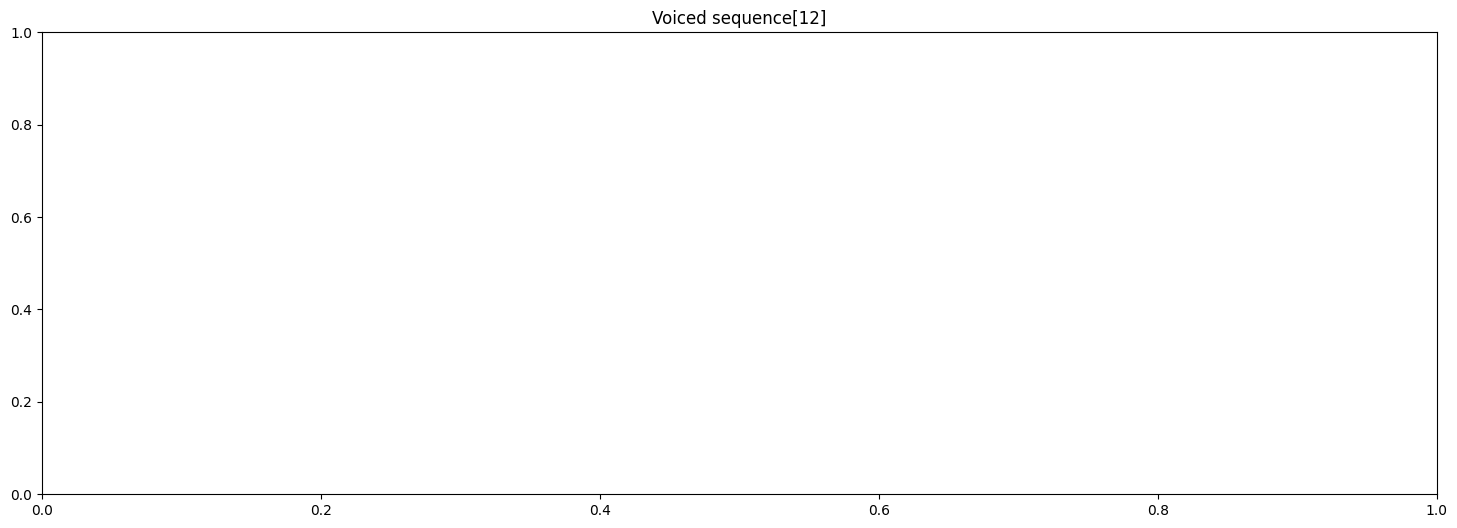

153 77 -76
227 77 -150
new
150 77 -73
221 77 -144
315 77 -238
new
238 77 -161
new
161 77 -84
241 77 -164
new
164 77 -87
245 77 -168
new
168 77 -91
254 77 -177
new
177 77 -100
260 77 -183
new
183 77 -106
266 77 -189
new
189 77 -112
273 77 -196
new
196 77 -119
279 77 -202
new
202 77 -125
284 77 -207
new
207 77 -130
288 68 -220
new
220 68 -152
307 68 -239
new
239 68 -171
new
171 68 -103
246 68 -178
new
178 68 -110
273 68 -205
new
205 68 -137
293 68 -225
new
225 68 -157
new
157 68 -89
238 68 -170
new
170 68 -102


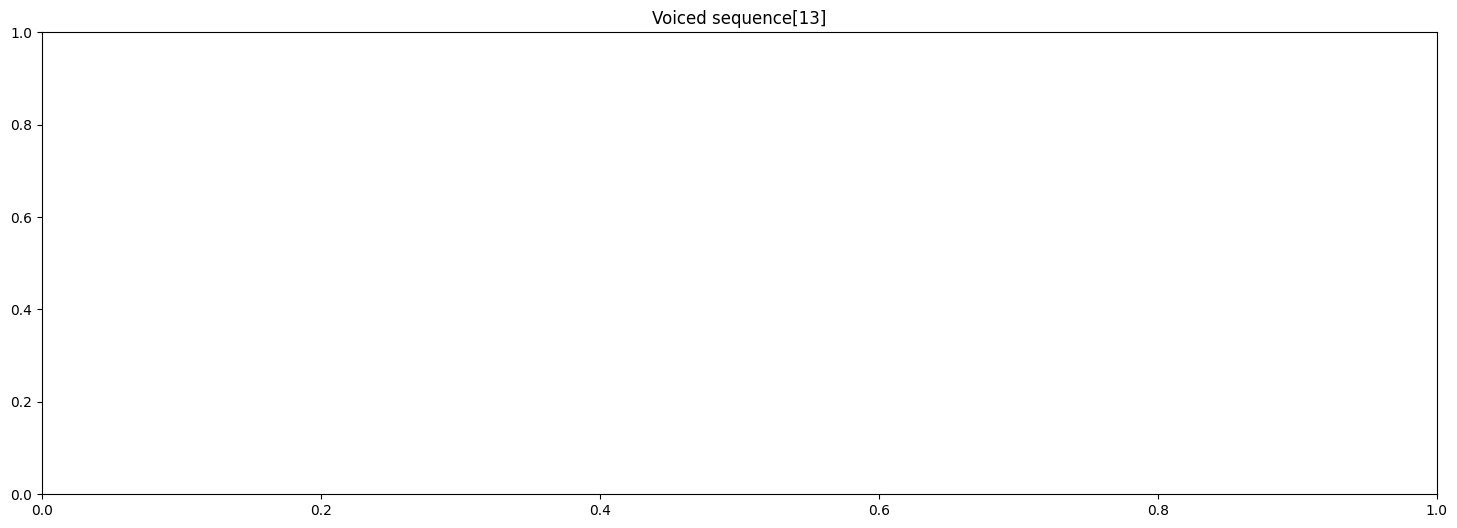

163 68 -95
247 68 -179
new
179 68 -111
262 68 -194
new
194 68 -126
282 68 -214
new
214 68 -146
303 68 -235
new
235 68 -167
new
167 68 -99
259 68 -191
new
191 68 -123
283 68 -215
new
215 68 -147
306 68 -238
new
238 68 -170
new
170 68 -102
263 68 -195
new
195 68 -127
285 68 -217
new
217 68 -149
305 68 -237
new
237 68 -169
new
169 68 -101
254 68 -186
new
186 68 -118
263 54 -209
new
209 54 -155
new
155 54 -101
247 54 -193
new
193 54 -139
294 54 -240
new
240 54 -186
new
186 54 -132
288 54 -234
new
234 54 -180
new
180 54 -126
281 54 -227
new
227 54 -173
new
173 54 -119
275 54 -221
new
221 54 -167
new
167 54 -113
269 54 -215
new
215 54 -161
new
161 54 -107
266 54 -212
new
212 54 -158
316 54 -262
new
262 54 -208
new
208 54 -154
new
154 54 -100
243 54 -189
new
189 54 -135
277 54 -223
new
223 54 -169
new
169 54 -115
319 54 -265
new
265 54 -211
new
211 54 -157
375 54 -321
new
321 54 -267
new
267 54 -213
new
213 54 -159
new
159 54 -105
263 54 -209
new
209 54 -155
330 54 -276
new
276 54 -222
new
22

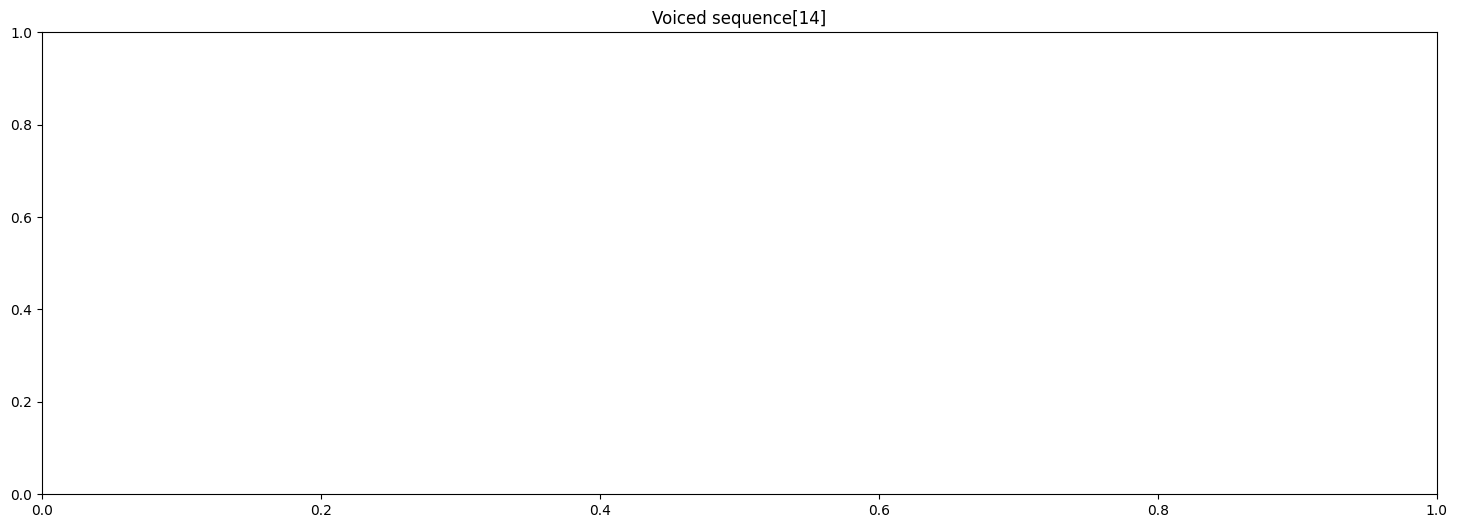

In [124]:
for j, psfs in enumerate(ps_seq_frames):
  i = 1
  leng = len(psfs)
  while i < leng:
    # preserve timing by not moving first and last frame
    if i == len(psfs) - 1:
      break
    lag = (psfs[i]['center'] - psfs[i-1]['center'])
    tl = curr_lag(psfs[i]['center'])
    shift = tl - lag
    print(lag, tl, shift)
    old_center = psfs[i]["center"]
    psfs[i]["center"]+=shift

    if np.abs(shift) > psfs[i]["fl"]:
      print("new")
      new = psfs[i].copy()
      new["center"] = old_center
      psfs.insert(i+1, new)
      leng += 1

    i += 1


  if PLOT:
    plt.figure(figsize=(18,6))
    plt.title(f"Voiced sequence[{j}]")
    plt.show()

### Synthesis

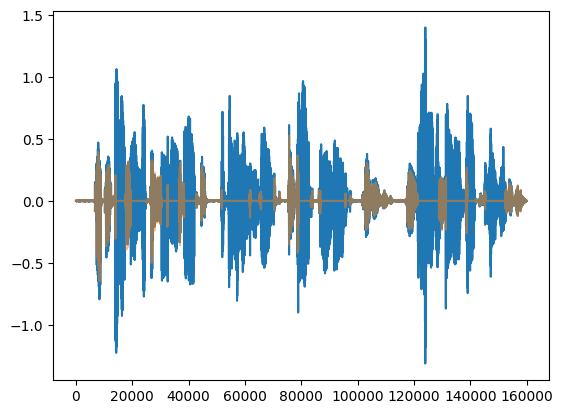

In [125]:
ss_u = s.copy()
unvoiced_s = np.zeros_like(s)
for i,v in enumerate(voiced):
  unvoiced_s[f_start(i):f_start(i)+fl] += 0.5*~v

ss_u *= unvoiced_s

ss = ss_u.copy()
for ps_seq in ps_seq_frames:
  for psf in ps_seq:
    ss[psf["center"]-psf["fl"]:psf["center"]+psf["fl"]] += psf["sig"]

ss = librosa.effects.deemphasis(ss, coef=0.2)

plt.plot(ss)
plt.plot(ss_u,alpha=0.5)
plt.show()
display(Audio(ss, rate=Fs))
display(Audio(s, rate=Fs))